fig1E: comparison between fetal and adult by gestation - ?Milo ? UMAP

# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
from pathlib import Path
import numpy as np
import numpy_groupies as npg
import pandas as pd

import anndata
import scanpy as sc
import sctk as sk

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import scipy
from sklearn.preprocessing import minmax_scale
import seaborn as sn

In [3]:
np.set_printoptions(linewidth=150)

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42

sc.settings.verbosity = 0
sk.set_figsize((4, 4))

In [4]:
from time import localtime, strftime


def timestamp(date_only=True):
    stamp_format = "%Y%m%d" if date_only else "%Y%m%d-%H%M"
    return strftime(stamp_format, localtime())

In [5]:
data_root = Path('/lustre/scratch126/cellgen/team205/nh3/skin').resolve()
proj_root = Path('~/FCA_Fetal_Skin_priv/').expanduser()
os.chdir(proj_root)
!pwd

/home/jovyan/FCA_Fetal_Skin_priv


# Load data

## fetal skin

In [6]:
fetal_ad0 = sc.read(Path(data_root, "20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad"))

In [7]:
fetal_ad0.shape

(186533, 28885)

what metadata is available in fetal skin?

In [8]:
fetal_ad0.obs.columns

Index(['sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample',
       'chemistry_sorting', 'cell_caller', 'scrublet_score',
       'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts',
       'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb',
       'independent_annotation_refined', 'independent_annotation_broad1',
       'independent_annotation_broad2', 'independent_annotation_broad3',
       'independent_annotation_broad4', 'independent_annotation_broad5',
       'joint_annotation', 'is_maternal', 'fig1b_annotation',
       'independent_annotation_refined_20220201a',
       'independent_annotation_refined_20220201b',
       'independent_annotation_broad1_20220201',
       'independent_annotation_broad2_20220201',
       'independent_annotation_broad3_20220201', 'joint_annotation_20220201a',
       'joint_annotation_20220201b', 'fig1b_annotation_20220201',
       'joint_annotation_20220202', 'independent_annotation_refined_20220202',
       'f

What's in "pcw"?

In [9]:
fetal_ad0.obs.pcw.value_counts(dropna=False).sort_index()

7     34565
8     13641
9     15310
10     5231
11    18465
12    13434
13     7211
14    25949
15    46656
16     6071
Name: pcw, dtype: int64

In [10]:
fetal_ad0.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435, 2.8572528], dtype=float32)

what's in "independent_annotation_broad5"?

In [11]:
fetal_ad0.obs.independent_annotation_broad5.value_counts(dropna=False).sort_index()

Epithelium      2263
Erythroid       3468
Immune         59019
Stroma        121783
Name: independent_annotation_broad5, dtype: int64

what's in "fib1b_annotation"

In [12]:
fetal_ad0.obs.fig1b_annotation_20220202.cat.categories

Index(['Adipocyte', 'B cell', 'Dermal papillia', 'Erythroid', 'Fibroblast',
       'ILC', 'Keratinocyte', 'Langerhans cell', 'Lymphatic endothelium',
       'Macrophage', 'Mast cell', 'Megakaryocyte', 'Melanocyte', 'Monocyte',
       'Mural cell', 'Myofibroblast', 'Neuronal cells', 'Neutrophil',
       'Progenitor', 'Schwann cell', 'Skeletal muscle', 'T cell',
       'Vascular endothelium', 'cDC', 'pDC'],
      dtype='object')

In [13]:
fetal_ad0.obs.fig1b_annotation_20220202.cat.rename_categories(
    {"Neuronal cells": "Neuronal cell"}, inplace=True
)

what's in "joint_annotation"

In [14]:
fetal_ad0.obs.loc[
    fetal_ad0.obs.independent_annotation_broad5 == "Epithelium", "joint_annotation_20220202"
].value_counts().where(lambda x: x > 0).dropna()

Basal                  815.0
Melanocyte             604.0
Matrix/placode         254.0
Melanoblast            190.0
Periderm               153.0
Immature basal          65.0
POSTN+ basal            46.0
Suprabasal IFE          30.0
Companion layer         27.0
Outer root sheath       25.0
Cuticle/cortex          21.0
Inner root sheath       18.0
Immature suprabasal     15.0
Name: joint_annotation_20220202, dtype: float64

what type of data is in "X"?

In [15]:
fetal_ad0.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435, 2.8572528], dtype=float32)

In [16]:
np.expm1(
    fetal_ad0.X[
        0:5,
    ]
).sum(axis=1)

matrix([[10005.071],
        [10006.827],
        [10006.456],
        [10006.766],
        [10001.346]], dtype=float32)

ok, seems it's log1p-transformed normalised values

## adult skin

In [17]:
adult_ad0 = sc.read(Path(data_root, "data/h5ad/Healthy_all_data.h5ad"))

In [18]:
adult_ad0.shape

(217266, 33538)

In [19]:
adult_ad0

AnnData object with n_obs × n_vars = 217266 × 33538
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'anno_final', 'final'
    var: 'gene_ids-SKN8090524', 'feature_types-SKN8090524', 'gene_ids-SKN8090525', 'feature_types-SKN8090525', 'gene_ids-SKN8090526', 'feature_types-SKN8090526', 'gene_ids-SKN8090527', 'feature_types-SKN8090527', 'gene_ids-SKN8090528', 'feature_types-SKN8090528', 'gene_ids-SKN8090529', 'feature_types-SKN8090529', 'gene_ids-SKN8090530', 'feature_types-SKN8090530', 'gene_ids-SKN8090531', 'feature_types-SKN8090531', 'gene_ids-SKN8090536', 'feature_types-SKN8090536', 'gene_ids-SKN8090537', 'feature_types-SKN8090537', 'gene_ids-SKN8090538', 'feature_types-SKN8090538', 'gene_ids-SKN8090539', 'feature_types-SKN8090539', 'gene_ids-SKN8090540', 'feature_types-SKN8090540', 'gene_ids-SKN8090541', 'feature_types-SKN8090541', 'gene_ids-SKN8090542', 'feature_types-SKN8090542', 'gene_ids-SKN80905

In [20]:
adult_ad0.var = adult_ad0.var[["gene_ids-SKN8090524", "feature_types-SKN8090524"]].rename(
    columns={"gene_ids-SKN8090524": "gene_ids", "feature_types-SKN8090524": "feature_types"}
)

In [21]:
adult_ad0.X.data

array([6., 2., 3., ..., 1., 2., 1.], dtype=float32)

In [22]:
sk.calculate_qc(adult_ad0)

what metadata is available in adult skin?

In [23]:
adult_ad0.obs.columns

Index(['sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue',
       'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage',
       'anno_final', 'final', 'n_counts', 'log1p_n_counts', 'n_genes',
       'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo',
       'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50'],
      dtype='object')

what's in "Age"?

In [24]:
adult_ad0.obs.Age.value_counts(dropna=False)

NaN    217266
Name: Age, dtype: int64

ok, basically no age information, set them to pcw 999 (40 + 18 * 52 = 976)

In [25]:
adult_ad0.obs["pcw"] = 999

there were some nan in cell type annotation in adult skin?

In [26]:
adult_ad0.obs.anno_final.value_counts(dropna=False).index.sort_values()

CategoricalIndex(['C_Melanocyte', 'DC1', 'DC2', 'F1', 'F2', 'F3', 'ILC1',
                  'ILC1_NK', 'ILC2_3', 'Inf_mono', 'LC_1', 'LC_2', 'LC_3',
                  'LC_4', 'LE1', 'LE2', 'M_A_Mast_cell', 'Macro_1', 'Macro_2',
                  'MigDC', 'Mono', 'NK', 'Pericyte_1_non_inflamm',
                  'Pericyte_2_inflamm', 'Plasma',
                  'Schwaan_1_Stroma_Schwan_myelinating',
                  'Schwaan_2_non_myelinating', 'Tc', 'Th', 'Treg', 'VE1',
                  'VE2', 'VE3', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8',
                  'moDC_1', 'moDC_2', 'moDC_3', 'nan'],
                 categories=['C_Melanocyte', 'DC1', 'DC2', 'F1', ..., 'moDC_1', 'moDC_2', 'moDC_3', 'nan'], ordered=False, dtype='category')

there's indeed nan, let's remove them

In [27]:
adult_ad0 = adult_ad0[adult_ad0.obs.anno_final.astype(str) != "nan"].copy()

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [28]:
adult_ad0.obs["anno_broad"] = sk.regroup(
    adult_ad0,
    groupby="anno_final",
    regroups={
        "ILC": ["ILC1", "ILC1_NK", "ILC2_3", "NK"],
        "T cell": ["Tc", "Th", "Treg"],
        "Plasma cell": ["Plasma"],
        "Monocyte": ["Inf_mono", "Mono"],
        "Macrophage": ["Macro_1", "Macro_2"],
        "cDC": ["DC1", "DC2", "MigDC", "moDC_1", "moDC_2", "moDC_3"],
        "Langerhans cell": ["LC_1", "LC_2", "LC_3", "LC_4"],
        "Mast cell": ["M_A_Mast_cell"],
        "Fibroblast": ["F1", "F2", "F3"],
        "Pericyte": ["Pericyte_1_non_inflamm", "Pericyte_2_inflamm"],
        "Keratinocyte": ["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8"],
        "Melanocyte": ["C_Melanocyte"],
        "Lymphatic endothelium": ["LE1", "LE2"],
        "Vascular endothelium": ["VE1", "VE2", "VE3"],
        "Schwann cell": ["Schwaan_1_Stroma_Schwan_myelinating", "Schwaan_2_non_myelinating"],
    },
)

In [29]:
adult_ad0.obs.anno_broad.value_counts(dropna=False).index

CategoricalIndex(['Keratinocyte', 'T cell', 'Vascular endothelium',
                  'Fibroblast', 'cDC', 'Langerhans cell', 'Macrophage', 'ILC',
                  'Monocyte', 'Pericyte', 'Lymphatic endothelium',
                  'Melanocyte', 'Mast cell', 'Schwann cell', 'Plasma cell'],
                 categories=['ILC', 'T cell', 'Plasma cell', 'Monocyte', ..., 'Melanocyte', 'Lymphatic endothelium', 'Vascular endothelium', 'Schwann cell'], ordered=False, dtype='category')

what type of data is in "X"?

In [30]:
adult_ad0.X.data

array([6., 2., 3., ..., 1., 2., 1.], dtype=float32)

In [31]:
adult_ad0

AnnData object with n_obs × n_vars = 195739 × 33538
    obs: 'sample_id', 'mad_prd', 'Status', 'Site', 'Site_old', 'Tissue', 'Enrichment', 'Location', 'donor_id', 'Sex', 'Age', 'stage', 'anno_final', 'final', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'pcw', 'anno_broad'
    var: 'gene_ids', 'feature_types', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

ok, seems it's raw counts

## skin organoid

In [32]:
organoid_ad0 = sc.read(Path(data_root, "data/h5ad/organoid_day13_29_48_85_133.cellxgene.h5ad"))

In [33]:
organoid_ad0.shape

(123835, 38072)

what metadata is available in organoid data?

In [34]:
organoid_ad0.obs.columns

Index(['day', 'sample_id', 'strain', 'version', 'week', 'nh3_annot1',
       'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes',
       'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo',
       'percent_hb', 'n_counts_hb', 'percent_top50', 'pass_auto_filter',
       'scrublet_score', 'scrublet_score_z', 'cluster_scrublet_score',
       'bh_pval', 'scrublet_done', 'doublet', 'seurat_clusters',
       'fsk_annot1_min30', 'fsk_annot1_min30_prob', 'fsk_annot2_min30',
       'fsk_annot2_min30_prob', 'day8to13', 'org_annot0', 'org_annot0_prob',
       'org_annot30', 'org_annot30_prob', 'fsk_annot0', 'fsk_annot0_prob',
       'fsk_annot30', 'fsk_annot30_prob'],
      dtype='object')

what's in "day"?

In [35]:
organoid_ad0.obs.day.value_counts(dropna=False).sort_index()

day-13      9557
day-29     16176
day-48     18898
day-85     15948
day-133    63256
Name: day, dtype: int64

what's in "week"?

In [36]:
organoid_ad0.obs.week.value_counts(dropna=False).sort_index()

4-7_fetal_wks      16176
7-10_fetal_wks     18898
14-16_fetal_wks    15948
17-20_fetal_wks    63256
nan                 9557
Name: week, dtype: int64

Set "pcw" from "day"

In [37]:
organoid_ad0.obs["pcw"] = (
    (organoid_ad0.obs.day.str.replace("day-", "").astype(int) / 7).round().astype(int)
)

what's in "strain"?

In [38]:
organoid_ad0.obs.strain.value_counts(dropna=False).sort_index()

DSP     65903
WA25    57932
Name: strain, dtype: int64

what's in "org_annot0"?

In [39]:
organoid_ad0.obs.org_annot0.value_counts(dropna=False).sort_index().index

CategoricalIndex(['organoid_Adipocytes', 'organoid_Basal',
                  'organoid_Basal POSTN+', 'organoid_Basal SHH+',
                  'organoid_Companion layer', 'organoid_Cuticle/cortex',
                  'organoid_Dermal condensate', 'organoid_Dermal papillia',
                  'organoid_Early fibroblasts FRZB+',
                  'organoid_Early fibroblasts HOXC5',
                  'organoid_Early myocytes', 'organoid_Fibroblasts POSTN+',
                  'organoid_Immature basal', 'organoid_Immature suprabasal',
                  'organoid_Inner root sheath', 'organoid_Melanoblasts',
                  'organoid_Melanocytes', 'organoid_Merkel cells',
                  'organoid_Myelinating Schwann cells', 'organoid_Myoblasts',
                  'organoid_Myocytes', 'organoid_Neuroepithelial cells',
                  'organoid_Neuron progenitors',
                  'organoid_Neuron progenitors SPP1+',
                  'organoid_Outer root sheath', 'organoid_Periderm',
 

make some broad annotations similar to that of fig1b_annotation in fetal skin

In [40]:
organoid_ad0.obs["org_annot0_broad"] = sk.regroup(
    organoid_ad0,
    groupby="org_annot0",
    regroups={
        "Adipocyte": ["organoid_Adipocytes"],
        "Dermal papillia": ["organoid_Dermal papillia"],
        "Fibroblast": [
            "organoid_Dermal condensate",
            "organoid_Early fibroblasts FRZB+",
            "organoid_Early fibroblasts HOXC5",
            "organoid_Fibroblasts POSTN+",
            "organoid_Pre-dermal condensate",
        ],
        "Keratinocyte": [
            "organoid_Basal",
            "organoid_Basal POSTN+",
            "organoid_Basal SHH+",
            "organoid_Companion layer",
            "organoid_Cuticle/cortex",
            "organoid_Immature basal",
            "organoid_Immature suprabasal",
            "organoid_Inner root sheath",
            "organoid_Outer root sheath",
            "organoid_Periderm",
            "organoid_Suprabasal IFE",
        ],
        "Melanocyte": [
            "organoid_Melanoblasts",
            "organoid_Proliferating melanoblasts",
            "organoid_Melanocytes",
        ],
        "Skeletal muscle": [
            "organoid_Early myocytes",
            "organoid_Myoblasts",
            "organoid_Myocytes",
        ],
        "Mural cell": ["organoid_Smooth muscle/Pericytes"],
        "Neuronal cell": [
            "organoid_Neuroepithelial cells",
            "organoid_Neuron progenitors",
            "organoid_Neuron progenitors SPP1+",
            "organoid_Secreting neuron",
            "organoid_Merkel cells",
        ],
        "Schwann cell": [
            "organoid_Myelinating Schwann cells",
            "organoid_Schwann cells/Schwann precursors",
        ],
        "Vascular endothelium": ["organoid_Tip cell (arterial)"],
    },
)
organoid_ad0.obs["org_annot0_broad"] = organoid_ad0.obs["org_annot0_broad"].astype("category")

In [41]:
np.expm1(
    organoid_ad0.X[
        0:5,
    ]
).sum(axis=1)

matrix([[ 9999.999],
        [10000.   ],
        [ 9999.999],
        [ 9999.999],
        [ 9999.998]], dtype=float32)

ok, seems it's log1p-transformed normalised values

# Down-sample and pool

In [42]:
fetal_adS = sk.subsample(fetal_ad0, 1, groupby="fig1b_annotation_20220202", min_n=500, max_n=500)

In [43]:
organoid_adS = sk.subsample(organoid_ad0, 1, groupby="org_annot0_broad", min_n=500, max_n=500)

In [44]:
adult_adS = sk.subsample(adult_ad0, 1, groupby="anno_broad", min_n=500, max_n=500)

In [45]:
pooled_adS = sk.integrate(
    [fetal_adS, organoid_adS, adult_adS],
    ad_prefices=["fetal", "organoid", "adult"],
    ad_types=["norm", "norm", "counts"],
    annotations=["fig1b_annotation_20220202", "org_annot0_broad", "anno_broad"],
    batches=["donor", "strain", "donor_id"],
    pool_only=True,
    join="outer",
)

In [46]:
pooled_adS

AnnData object with n_obs × n_vars = 23285 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [47]:
pooled_adS.var["n_counts"] = (
    pooled_adS.var["n_counts-adult"].fillna(0)
    + pooled_adS.var["n_counts-fetal"].fillna(0)
    + pooled_adS.var["n_counts-organoid"].fillna(0)
)

pooled_adS.var["n_cells"] = (
    pooled_adS.var["n_cells-adult"].fillna(0)
    + pooled_adS.var["n_cells-fetal"].fillna(0)
    + pooled_adS.var["n_cells-organoid"].fillna(0)
)

In [48]:
pooled_adS

AnnData object with n_obs × n_vars = 23285 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [49]:
pooled_adS.var.mito.value_counts(dropna=False)

False    46781
True        13
Name: mito, dtype: int64

In [50]:
sk.calculate_qc(pooled_adS, flag_only=True)

In [51]:
pooled_adS.var = pooled_adS.var[["mito", "ribo", "hb", "n_counts", "n_cells"]].copy()

In [52]:
pooled_adS

AnnData object with n_obs × n_vars = 23285 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [53]:
pooled_adS.obs.pcw.value_counts(dropna=False).sort_index()

2       553
4       377
7      2350
8       319
9       683
10      105
11     1420
12     1737
13      464
14     1925
15     3799
16      529
19     2184
999    6840
Name: pcw, dtype: int64

In [54]:
pooled_adS.obs['log2pcw'] = np.log2(pooled_adS.obs.pcw)

In [55]:
pooled_adS.obs.batch.value_counts(dropna=False).sort_index()

DSP     2615
F16       76
F17       45
F19      105
F32      260
F33      638
F34      243
F35      316
F38     1107
F41      529
F45      464
F50     1669
F51     2130
F61      887
F69     1420
F71     1925
S1      1642
S2       903
S3       584
S4      1695
S5      2016
WA25    2016
Name: batch, dtype: int64

In [56]:
pooled_adS.obs.dataset.value_counts(dropna=False).sort_index()

fetal       11814
organoid     4631
adult        6840
Name: dataset, dtype: int64

In [57]:
pooled_adS.obs.annot.value_counts(dropna=False).sort_index()

adult_Fibroblast                 500
adult_ILC                        500
adult_Keratinocyte               500
adult_Langerhans cell            500
adult_Lymphatic endothelium      500
adult_Macrophage                 500
adult_Mast cell                  500
adult_Melanocyte                 500
adult_Monocyte                   500
adult_Pericyte                   500
adult_Plasma cell                 71
adult_Schwann cell               269
adult_T cell                     500
adult_Vascular endothelium       500
adult_cDC                        500
fetal_Adipocyte                  500
fetal_B cell                     500
fetal_Dermal papillia            500
fetal_Erythroid                  500
fetal_Fibroblast                 500
fetal_ILC                        500
fetal_Keratinocyte               500
fetal_Langerhans cell            379
fetal_Lymphatic endothelium      500
fetal_Macrophage                 500
fetal_Mast cell                  500
fetal_Megakaryocyte              173
f

In [61]:
pooled_adS1 = sk._pipeline.simple_default_pipeline(
    pooled_adS.copy(),
    post_norm_only=True,
    batch_method="harmony",
    batch=["dataset", "batch"],
    do_clustering=False,
    hvg_kw={"by_batch": ("dataset", 1), "n_hvg": 2000, "subset": True},
    pca_kw={"remove_genes": ["ribo", "mito"]},
)

... storing 'batch' as categorical
... storing 'is_maternal' as categorical
... storing 'annot' as categorical
... storing 'sample_id' as categorical
... storing 'pass_auto_filter' as categorical
... storing 'doublet' as categorical
... storing 'mad_prd' as categorical
2022-11-15 17:17:02,231 - harmonypy - INFO - Iteration 1 of 20
2022-11-15 17:17:13,403 - harmonypy - INFO - Iteration 2 of 20
2022-11-15 17:17:23,756 - harmonypy - INFO - Iteration 3 of 20
2022-11-15 17:17:33,321 - harmonypy - INFO - Iteration 4 of 20
2022-11-15 17:17:43,723 - harmonypy - INFO - Iteration 5 of 20
2022-11-15 17:17:53,447 - harmonypy - INFO - Converged after 5 iterations


In [62]:
np.expm1(pooled_adS1.X[0:5, :]).sum(axis=1)

matrix([[ 618439.56],
        [ 882418.4 ],
        [1189812.5 ],
        [ 863587.75],
        [ 842456.8 ]], dtype=float32)

In [63]:
np.expm1(pooled_adS1.raw.X[0:5, :]).sum(axis=1)

matrix([[ 9949.203],
        [ 9961.426],
        [ 9948.032],
        [10072.695],
        [ 9949.528]], dtype=float32)

In [64]:
pooled_adS1.X.data

array([1.1900462 , 0.7911941 , 0.67896783, ..., 2.0408351 , 2.7177544 , 2.4809973 ], dtype=float32)

In [65]:
pooled_adS1.obs["log2pcw"] = np.log2(pooled_adS1.obs.pcw)
pooled_adS1.obs["log2pcw"] = pooled_adS1.obs["log2pcw"].astype("category")

In [66]:
pooled_adS1

AnnData object with n_obs × n_vars = 23285 × 29897
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [ ]:
import harmonypy

In [ ]:
harmonypy

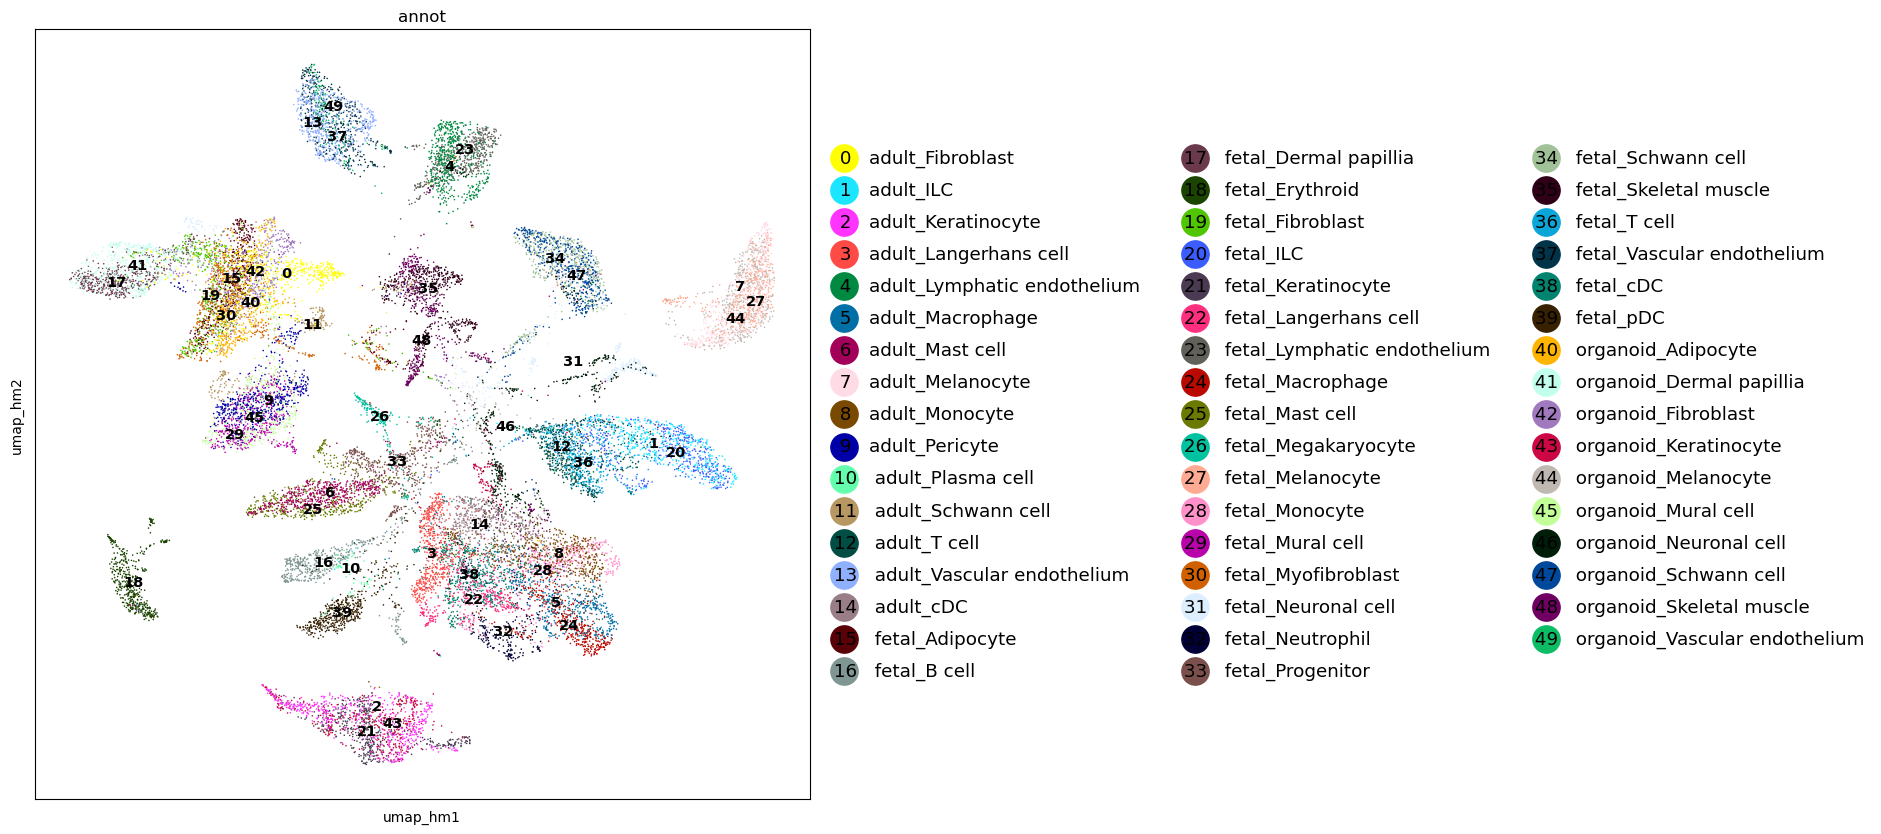

In [67]:
sk.plot_embedding(
    pooled_adS1, basis="umap_hm", groupby="annot", figsize=(10, 10), legend_fontsize=12
);

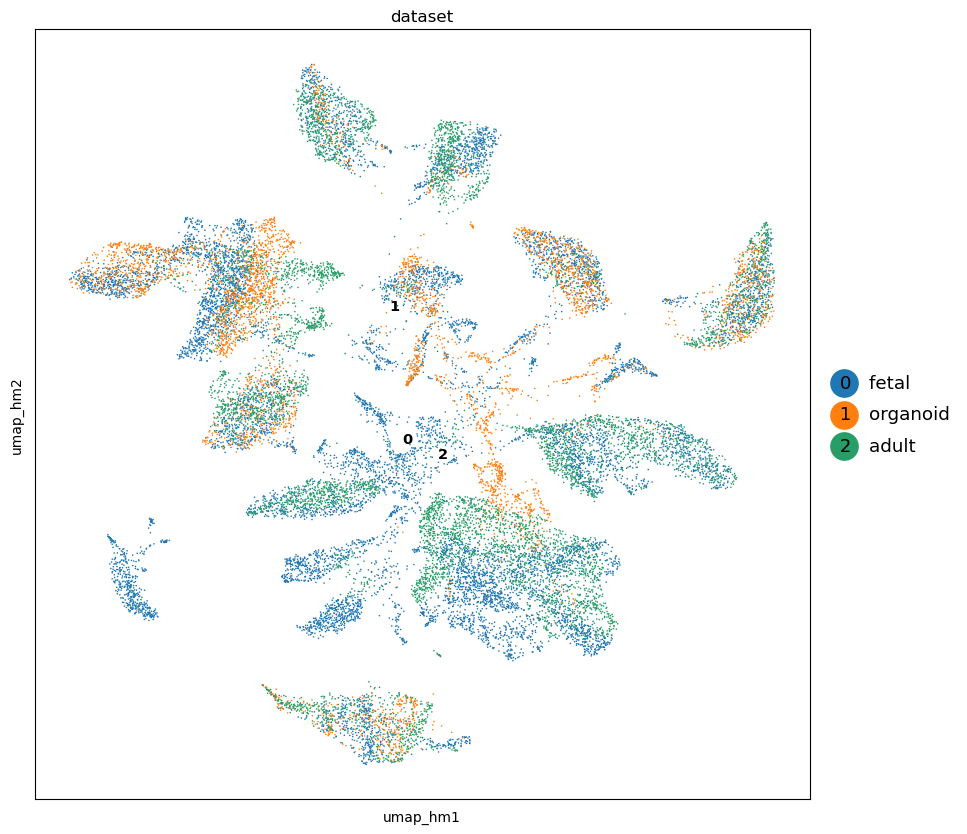

In [68]:
sk.plot_embedding(
    pooled_adS1, basis="umap_hm", groupby="dataset", figsize=(10, 10), legend_fontsize=12
);

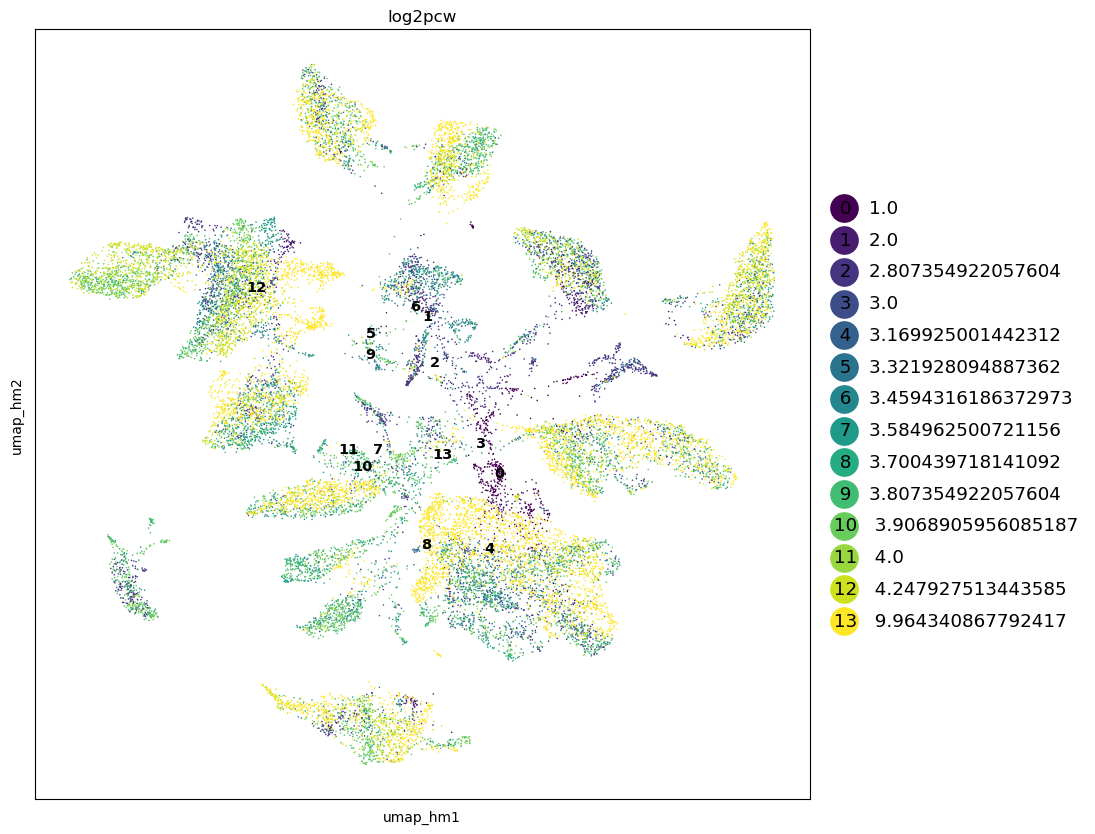

In [69]:
sk.plot_embedding(
    pooled_adS1,
    basis="umap_hm",
    groupby="log2pcw",
    figsize=(10, 10),
    palette="viridis",
    legend_fontsize=12,
);

In [59]:
# pooled_adS1.write(
#     "pooled_fetal_organoid_adult.downsampled.harmony_integrated.norm.h5ad", compression="lzf"
# )

In [70]:
pooled_adS1 = sc.read(Path(data_root, "20211022_final_figures/h5ad/pooled_fetal_organoid_adult.downsampled.harmony_integrated.norm.h5ad"))

# Pool

pool fetal and adult with the union of genes

In [71]:
pooled_ad0 = sk.integrate(
    [fetal_ad0, organoid_ad0, adult_ad0],
    ad_prefices=["fetal", "organoid", "adult"],
    ad_types=["norm", "norm", "counts"],
    annotations=["fig1b_annotation_20220202", "org_annot0_broad", "anno_broad"],
    batches=["donor", "strain", "donor_id"],
    pool_only=True,
    join="outer",
)

In [72]:
pooled_ad0.var["n_counts"] = (
    pooled_ad0.var["n_counts-adult"].fillna(0)
    + pooled_ad0.var["n_counts-fetal"].fillna(0)
    + pooled_ad0.var["n_counts-organoid"].fillna(0)
)

In [73]:
pooled_ad0.var["n_cells"] = (
    pooled_ad0.var["n_cells-adult"].fillna(0)
    + pooled_ad0.var["n_cells-fetal"].fillna(0)
    + pooled_ad0.var["n_cells-organoid"].fillna(0)
)

In [74]:
sk.calculate_qc(pooled_ad0, flag_only=True)

In [75]:
pooled_ad0.var = pooled_ad0.var[["mito", "ribo", "hb", "n_counts", "n_cells"]].copy()

In [76]:
# pooled_ad0.write("pooled_fetal_organoid_adult.norm.h5ad", compression="lzf")

# Integrate

In [77]:
pooled_ad0 = sc.read(Path(data_root, "20211022_final_figures/h5ad/pooled_fetal_organoid_adult.norm.h5ad"))

In [78]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_

In [79]:
pooled_adS1

AnnData object with n_obs × n_vars = 23285 × 29897
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_a

In [80]:
pooled_adS2 = pooled_adS1[:, pooled_adS1.var.highly_variable].copy()

In [81]:
proj_results = sk._utils.project_into_PC(
    pooled_ad0, pooled_adS2, target_pca="X_pca_hm", key_added="project"
)

In [82]:
sk.neighbors(pooled_ad0, use_rep="X_pca_project", key_added="project")
sk.umap(pooled_ad0, use_graph="neighbors_project")

In [83]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_

In [84]:
pooled_ad0.obs["log2pcw"] = np.log2(pooled_ad0.obs.pcw)

In [85]:
pooled_ad0.obs.annot.cat.rename_categories({"adult_Pericyte": "adult_Mural cell"}, inplace=True)

<AxesSubplot: title={'center': 'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

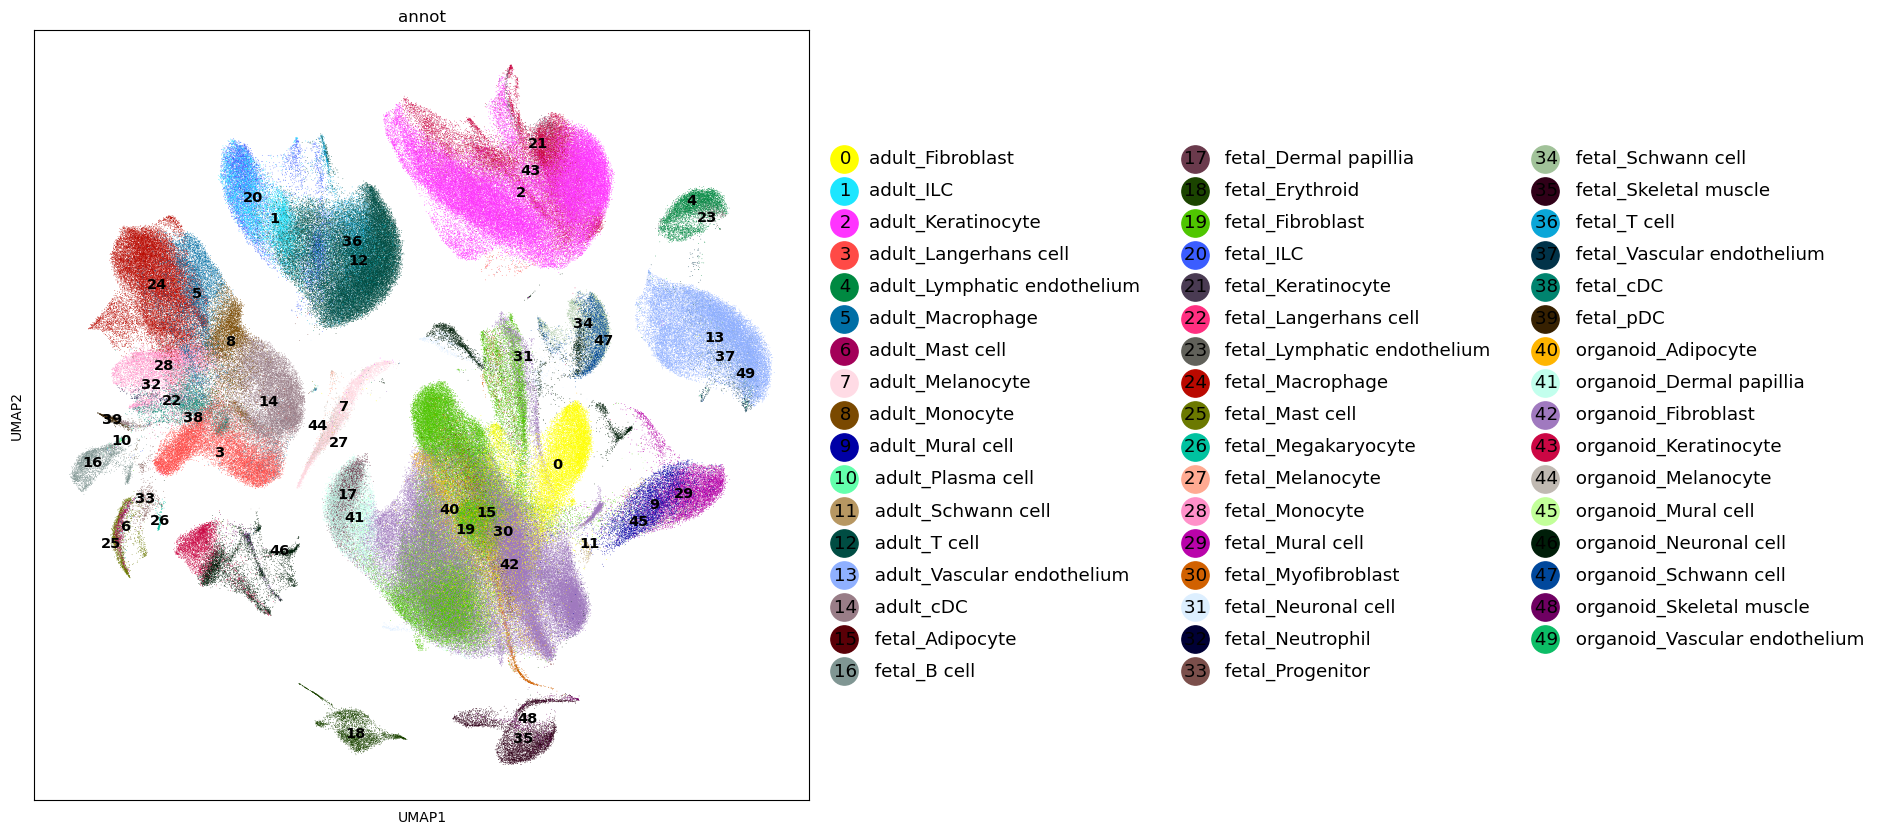

In [86]:
sk.plot_embedding(
    pooled_ad0,
    basis="umap",
    groupby="annot",
    figsize=(10, 10),
    legend_fontsize=12,
    size=1,
)

In [76]:
# pooled_ad0.write("pooled_fetal_organoid_adult.processed.h5ad", compression="lzf")

In [77]:
# !rclone copy pooled_fetal_organoid_adult.processed.h5ad google:/projects/fetal_skin/data/h5ad/20220224_fetal_organoid_adult_object/

figS1E

In [87]:
pooled_ad0 = sc.read(Path(data_root, "20211022_final_figures/h5ad/pooled_fetal_organoid_adult.processed.h5ad", backed="r"))

<AxesSubplot: title={'center': 'annot'}, xlabel='UMAP1', ylabel='UMAP2'>

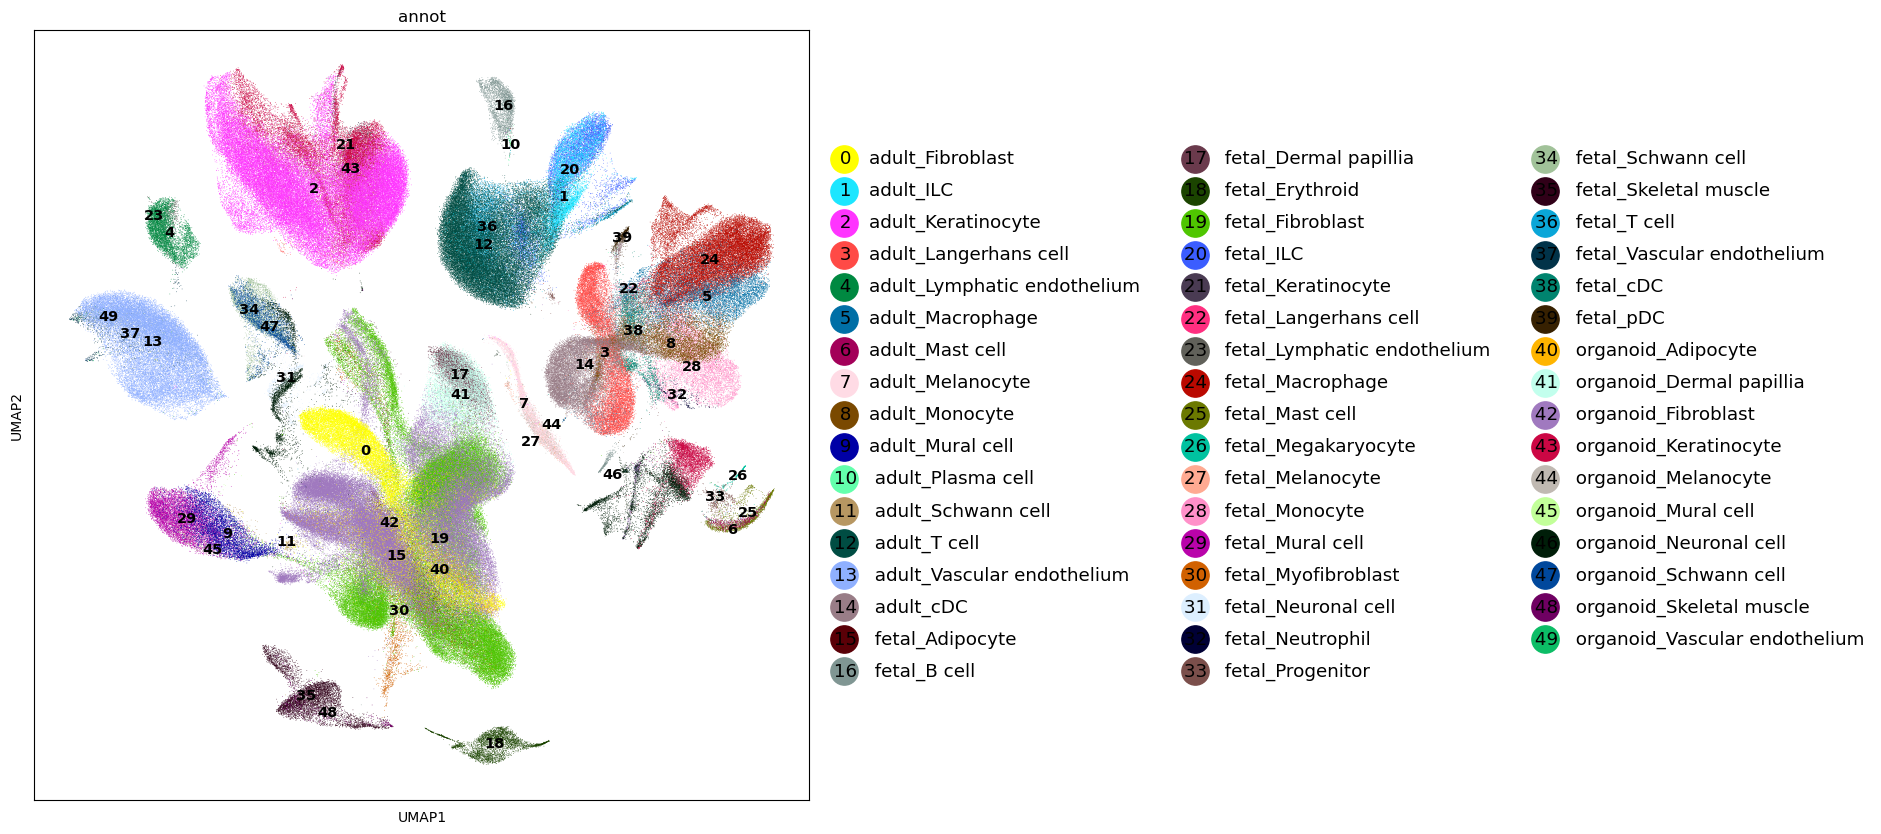

In [88]:
sk.plot_embedding(
    pooled_ad0,
    basis="umap",
    groupby="annot",
    figsize=(10, 10),
    legend_fontsize=12,
    size=1,
)

In [89]:
%%capture

with PdfPages("figures/final/figS1G.pdf") as pdf:
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(15, 15),
        legend_fontsize=12,
        size=2,
    )
    pdf.savefig(bbox_inches="tight")
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(15, 15),
        legend_fontsize=12,
        size=2,
        annot="none",
        frameon=False,
    )
    pdf.savefig(bbox_inches="tight")

In [90]:
# !rclone copy --drive-shared-with-me figures/figS1E.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [91]:
%%capture

sc.settings.set_figure_params(dpi_save=80)
with PdfPages("figures/final/figS1G_smaller.pdf") as pdf:
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(10, 10),
        legend_fontsize=12,
        size=0.75,
    )
    pdf.savefig(bbox_inches="tight")
    sk.plot_embedding(
        pooled_ad0,
        basis="umap",
        groupby="annot",
        figsize=(10, 10),
        legend_fontsize=12,
        size=0.75,
        annot="none",
        frameon=False,
    )
    pdf.savefig(bbox_inches="tight", dpi=80)

In [92]:
# !rclone copy --drive-shared-with-me figures/figS1E_smaller.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

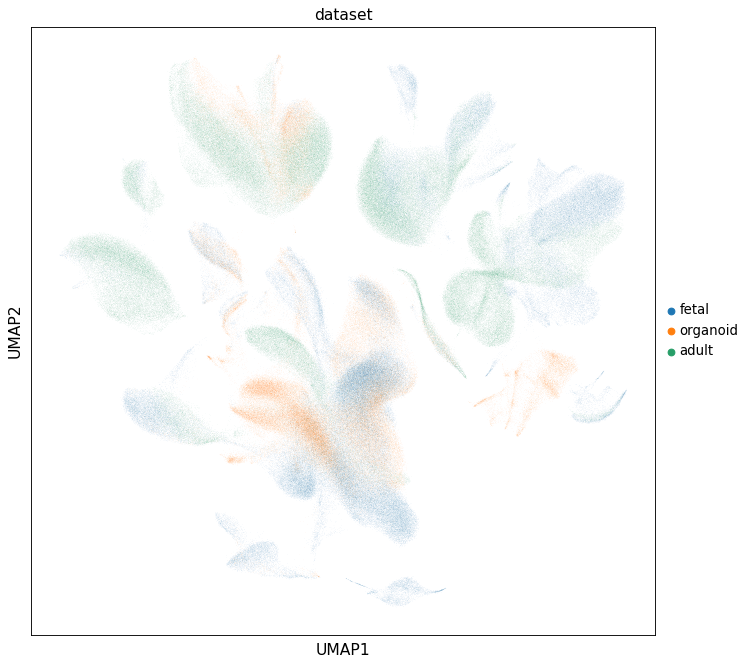

In [93]:
sc.pl.embedding(pooled_ad0, basis="umap", color="dataset", legend_fontsize=12, size=0.1);

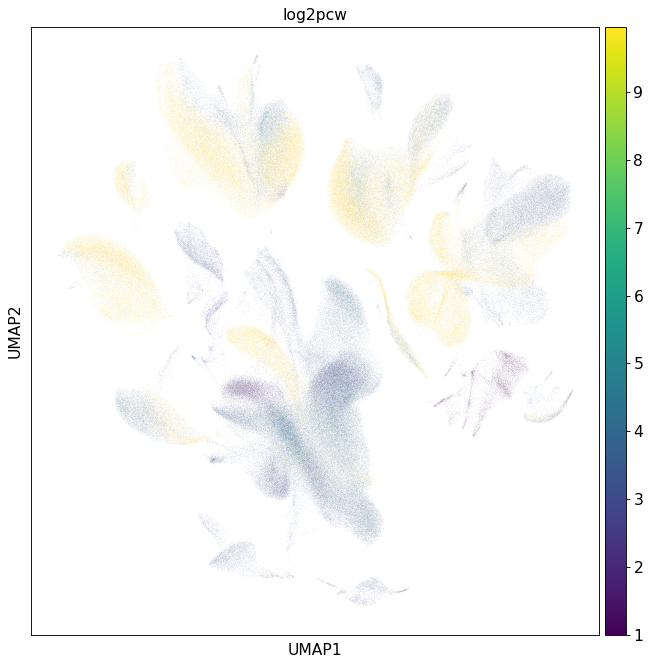

In [94]:
sc.pl.embedding(pooled_ad0, basis="umap", color="log2pcw", legend_fontsize=12, size=0.1);

# Distance calculation

## fetal vs adult vs organoid

In [95]:
pooled_ad0 = sc.read(Path(data_root, "20211022_final_figures/h5ad/pooled_fetal_organoid_adult.processed.h5ad", backed="r"))

In [96]:
pooled_ad0

AnnData object with n_obs × n_vars = 506107 × 46794
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_

In [97]:
pb_annot_pca = sk.pseudo_bulk(pooled_ad0, groupby="annot", use_rep="X_pca_project", FUN=np.median).T

In [98]:
annot_dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca.values, pb_annot_pca.values),
    index=pb_annot_pca.index,
    columns=pb_annot_pca.index,
)

In [99]:
annot_dist_df.iloc[0:5, 0:5]

adult_Fibroblast  adult_ILC  adult_Keratinocyte  \
adult_Fibroblast                     0.000000  24.446382           22.663383   
adult_ILC                           24.446382   0.000000           21.660081   
adult_Keratinocyte                  22.663383  21.660081            0.000000   
adult_Langerhans cell               23.395505  19.662860           19.766183   
adult_Lymphatic endothelium         22.293357  24.628276           22.577697   

                             adult_Langerhans cell  \
adult_Fibroblast                         23.395505   
adult_ILC                                19.662860   
adult_Keratinocyte                       19.766183   
adult_Langerhans cell                     0.000000   
adult_Lymphatic endothelium              23.455877   

                             adult_Lymphatic endothelium  
adult_Fibroblast                               22.293357  
adult_ILC                                      24.628276  
adult_Keratinocyte                             22.577697  
adult_Langerhans cell                          23.455877  
adult_Lymphatic endothelium                     0.000000

In [100]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [101]:
annot_dist_df_shared = annot_dist_df.loc[
    annot_dist_df.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
    annot_dist_df.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
]

In [102]:
annot_scaled_dist_df_shared = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df_shared)),
    index=annot_dist_df_shared.index,
    columns=annot_dist_df_shared.index,
)

In [103]:
annot_scaled_dist_df_shared.columns

Index(['adult_Fibroblast', 'adult_Keratinocyte', 'adult_Melanocyte',
       'adult_Mural cell', 'adult_Schwann cell', 'adult_Vascular endothelium',
       'fetal_Fibroblast', 'fetal_Keratinocyte', 'fetal_Melanocyte',
       'fetal_Mural cell', 'fetal_Schwann cell', 'fetal_Vascular endothelium',
       'organoid_Fibroblast', 'organoid_Keratinocyte', 'organoid_Melanocyte',
       'organoid_Mural cell', 'organoid_Schwann cell',
       'organoid_Vascular endothelium'],
      dtype='object')

In [104]:
fig1d_ct_order = [
    "adult_Keratinocyte",
    "fetal_Keratinocyte",
    "organoid_Keratinocyte",
    "adult_Melanocyte",
    "fetal_Melanocyte",
    "organoid_Melanocyte",
    "adult_Mural cell",
    "fetal_Mural cell",
    "organoid_Mural cell",
    "adult_Fibroblast",
    "fetal_Fibroblast",
    "organoid_Fibroblast",
    "adult_Schwann cell",
    "fetal_Schwann cell",
    "organoid_Schwann cell",
    "adult_Vascular endothelium",
    "fetal_Vascular endothelium",
    "organoid_Vascular endothelium",
]

fig1d_df = annot_scaled_dist_df_shared[fig1d_ct_order].loc[fig1d_ct_order].T

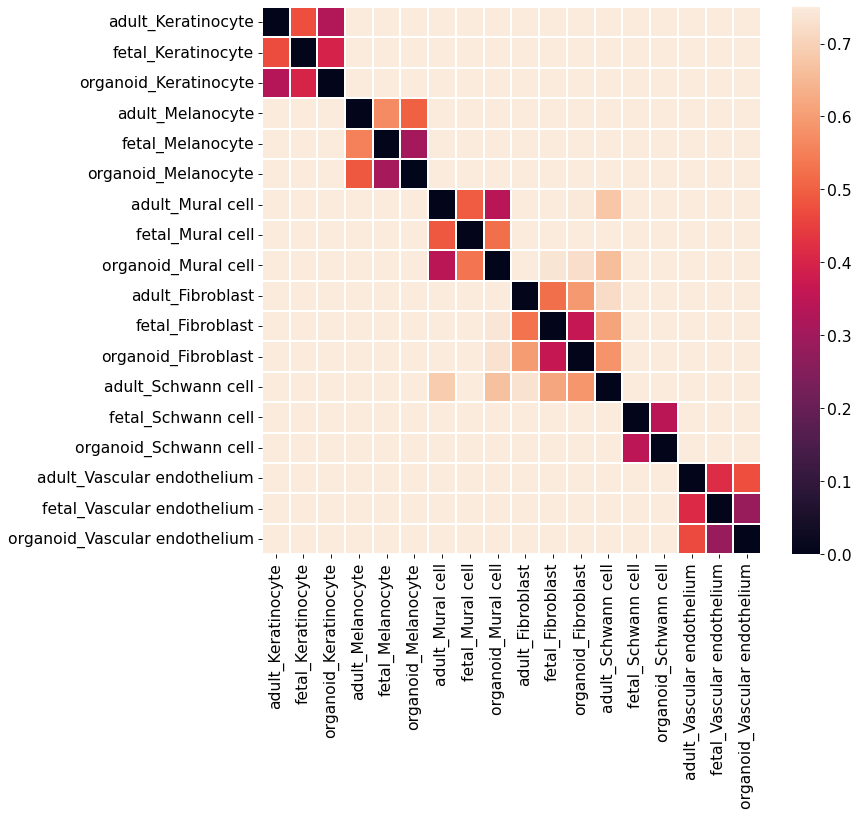

In [105]:
fig1D_g = sk.heatmap(fig1d_df, figsize=(10, 9), vmax=0.75, linewidth=0.01)
fig1D_g.figure.savefig("figures/final/fig1E.20220718.pdf", bbox_inches="tight")

In [106]:
# !rclone copy --drive-shared-with-me figures/fig1E.20220718.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

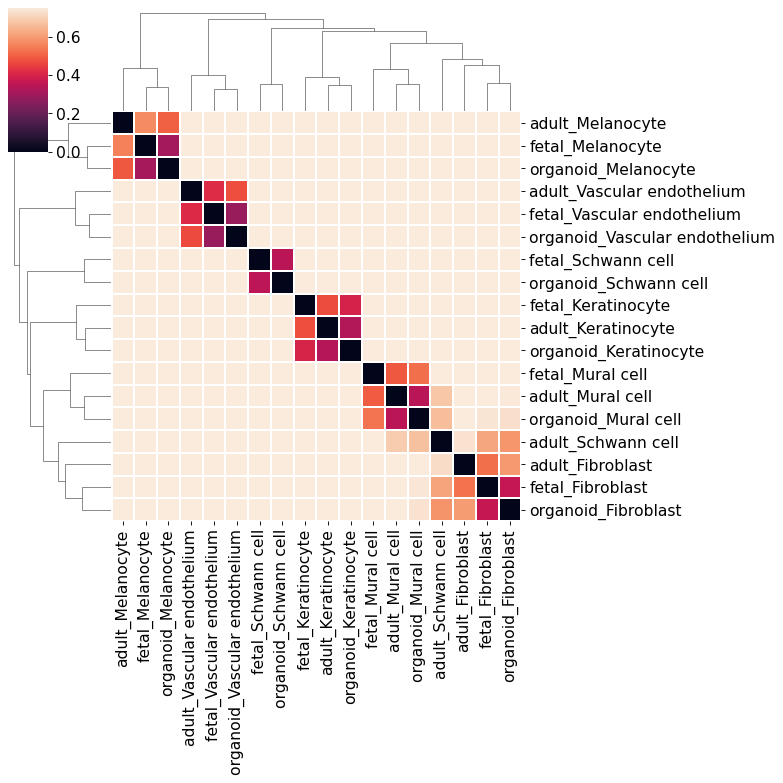

In [107]:
fig1D_g = sn.clustermap(annot_scaled_dist_df_shared.T, figsize=(10, 10), vmax=0.75, linewidth=0.01)
fig1D_g.savefig("figures/obsolete/fig1D_p1a.pdf")

In [108]:
annot_scaled_dist_df_shared = annot_scaled_dist_df_shared.loc[
    ~annot_scaled_dist_df_shared.index.str.startswith("fetal_"),
    annot_scaled_dist_df_shared.index.str.startswith("fetal_"),
]

fig1D part1

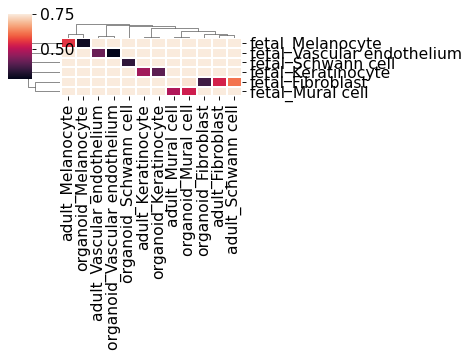

In [109]:
fig1D_g = sn.clustermap(annot_scaled_dist_df_shared.T, figsize=(6, 4.5), vmax=0.75, linewidth=0.01)
fig1D_g.savefig("figures/obsolete/fig1D_p1b.pdf")

In [110]:
# !rclone copy --drive-shared-with-me figures/fig1D_p1.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [111]:
annot_scaled_dist_df = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df)),
    index=annot_dist_df.index,
    columns=annot_dist_df.index,
)

In [112]:
figS1h_ct_order = [
    "adult_Keratinocyte",
    "fetal_Keratinocyte",
    "organoid_Keratinocyte",
    "adult_Melanocyte",
    "fetal_Melanocyte",
    "organoid_Melanocyte",
    "adult_Mural cell",
    "fetal_Mural cell",
    "organoid_Mural cell",
    "fetal_Dermal papillia",
    "organoid_Dermal papillia",
    "adult_Fibroblast",
    "fetal_Fibroblast",
    "fetal_Myofibroblast",
    "organoid_Fibroblast",
    "fetal_Adipocyte",
    "organoid_Adipocyte",
    "adult_Schwann cell",
    "fetal_Schwann cell",
    "organoid_Schwann cell",
    "adult_Vascular endothelium",
    "fetal_Vascular endothelium",
    "organoid_Vascular endothelium",
    "adult_Lymphatic endothelium",
    "fetal_Lymphatic endothelium",
    "fetal_Neuronal cell",
    "organoid_Neuronal cell",
    "fetal_Progenitor",
    "adult_Langerhans cell",
    "fetal_Langerhans cell",
    "adult_cDC",
    "fetal_cDC",
    "adult_Monocyte",
    "fetal_Monocyte",
    "adult_Macrophage",
    "fetal_Macrophage",
    "adult_Mast cell",
    "fetal_Mast cell",
    "fetal_Neutrophil",
    "adult_ILC",
    "fetal_ILC",
    "adult_T cell",
    "fetal_T cell",
    "fetal_pDC",
    "fetal_B cell",
    "adult_Plasma cell",
    "fetal_Skeletal muscle",
    "organoid_Skeletal muscle",
    "fetal_Erythroid",
    "fetal_Megakaryocyte",
]

figS1h_df = annot_scaled_dist_df[figS1h_ct_order].loc[figS1h_ct_order]

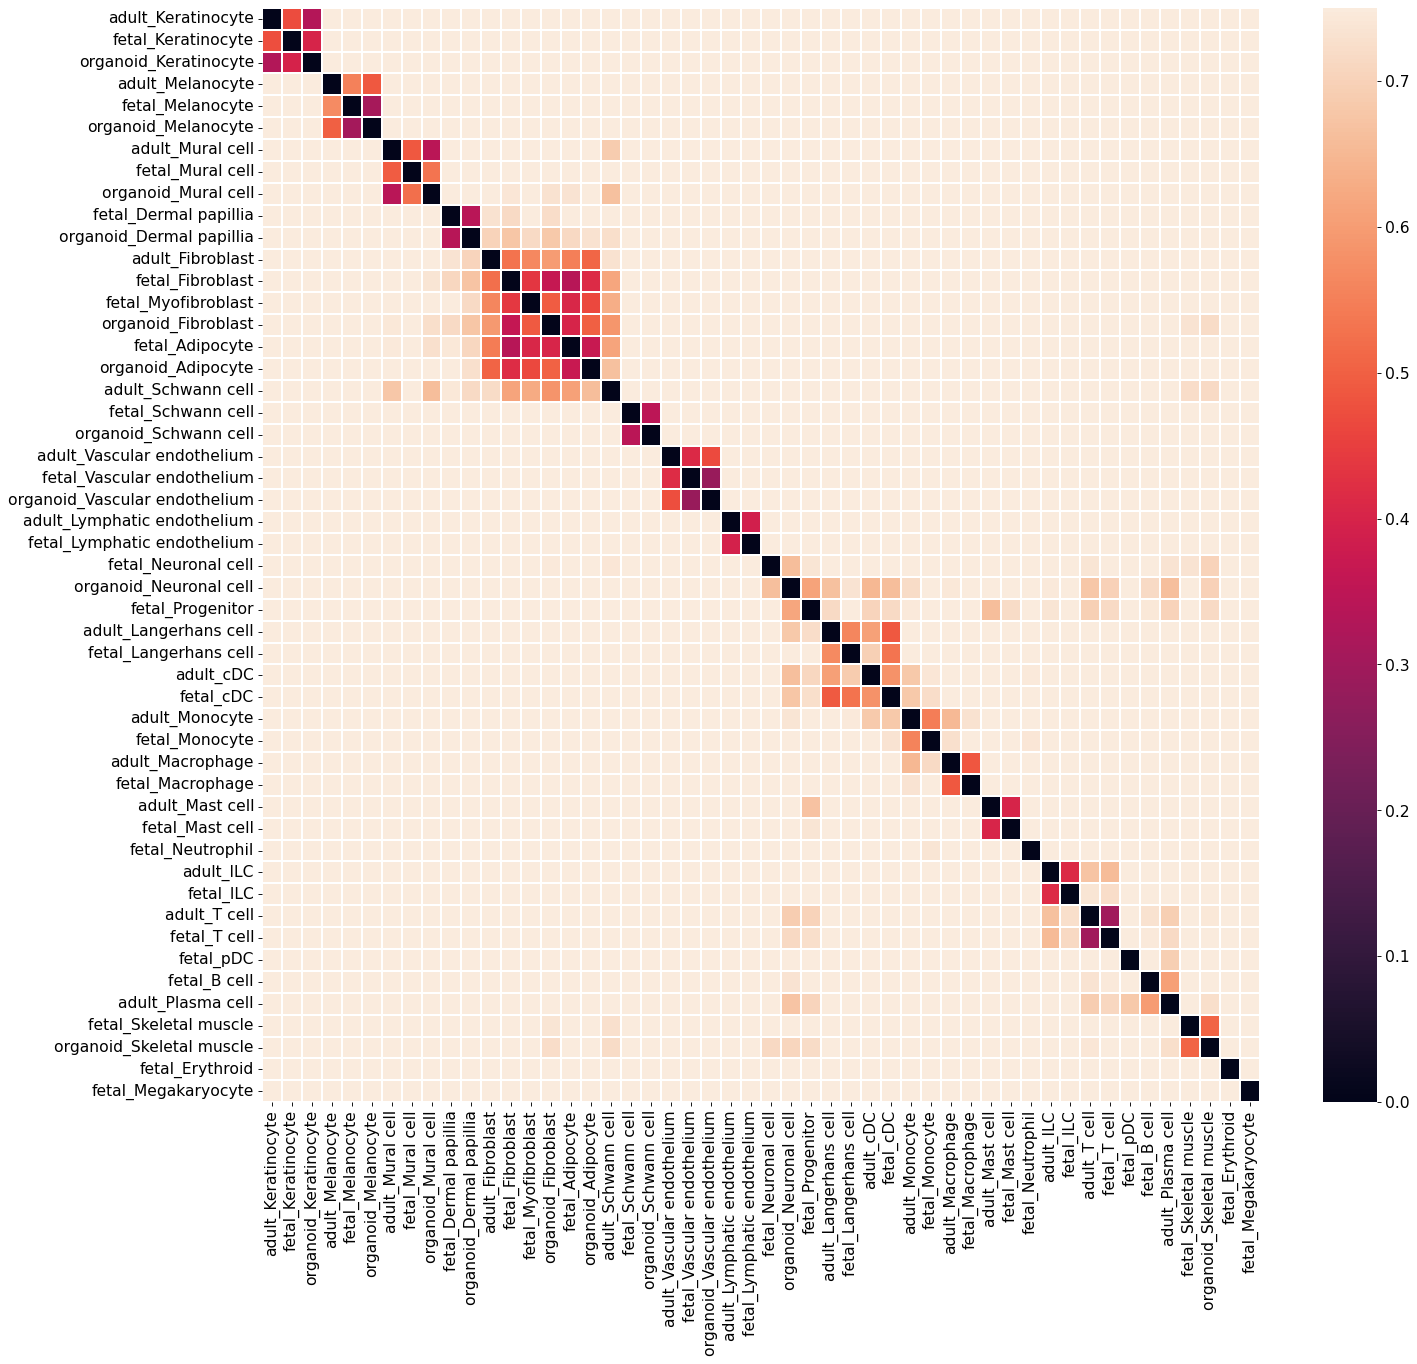

In [113]:
figS1h_g = sk.heatmap(figS1h_df, figsize=(20, 18), vmax=0.75, linewidth=0.01)
figS1h_g.figure.savefig("figures/final/figS1I.pdf", bbox_inches="tight")

In [114]:
# !rclone copy --drive-shared-with-me figures/figS1h.20220718.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

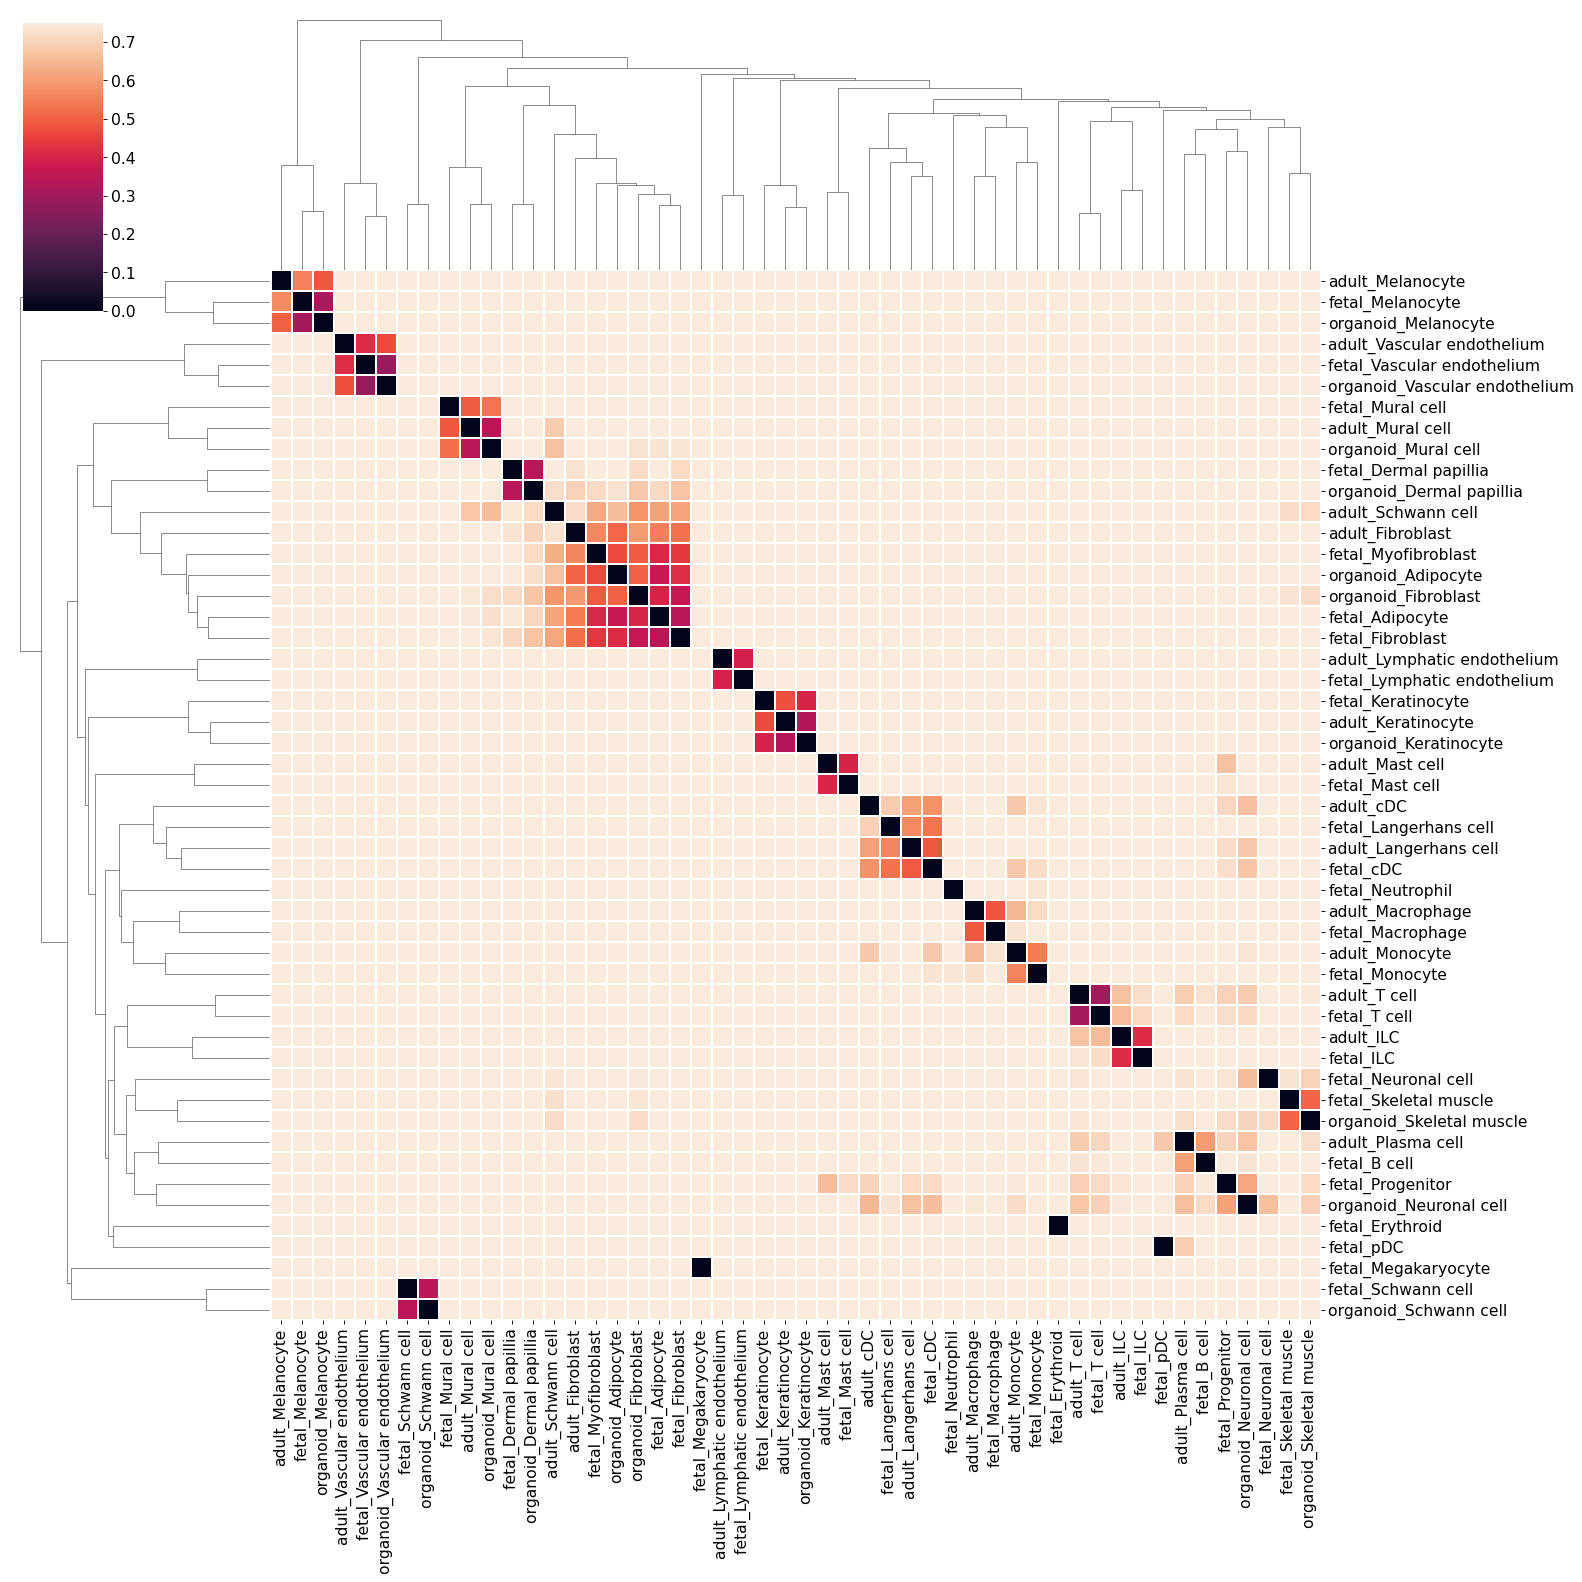

In [115]:
figS1F_g = sn.clustermap(annot_scaled_dist_df, figsize=(20, 20), vmax=0.75, linewidth=0.01)
figS1F_g.savefig("figures/obsolete/figS1F_p1.pdf")

In [116]:
# !rclone copy --drive-shared-with-me figures/figS1F_p1.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

## early/late fetal vs adult vs organoid

### define early/late by milo analysis

In [117]:
early_fsk_cells = pd.read_csv(
    Path(data_root, "20211022_final_figures/milo/fetal_skin.scvi_donor.milo.fig1b_annotation_vs_pcw.early_cells.list"), names=["cell"]
).cell
late_fsk_cells = pd.read_csv(
    Path(data_root, "20211022_final_figures/milo/fetal_skin.scvi_donor.milo.fig1b_annotation_vs_pcw.late_cells.list"), names=["cell"]
).cell

In [118]:
tmp_cells = early_fsk_cells[early_fsk_cells.isin(late_fsk_cells)]

In [119]:
tmp_cells.size

936

In [120]:
early_fsk_cells = early_fsk_cells[~early_fsk_cells.isin(tmp_cells)]
late_fsk_cells = late_fsk_cells[~late_fsk_cells.isin(tmp_cells)]

### broad annotation

In [121]:
pooled_ad0.obs["annot_early_late"] = pooled_ad0.obs.annot.astype(str)
k_early_fsk = pooled_ad0.obs_names.isin(early_fsk_cells + "-fetal")
k_late_fsk = pooled_ad0.obs_names.isin(late_fsk_cells + "-fetal")
pooled_ad0.obs.loc[k_early_fsk, "annot_early_late"] = (
    "early-" + pooled_ad0.obs.loc[k_early_fsk, "annot_early_late"]
)
pooled_ad0.obs.loc[k_late_fsk, "annot_early_late"] = (
    "late-" + pooled_ad0.obs.loc[k_late_fsk, "annot_early_late"]
)
pooled_ad0.obs["annot_early_late"] = pooled_ad0.obs["annot_early_late"].astype("category")

In [122]:
pb_annot_pca2 = sk.pseudo_bulk(
    pooled_ad0, groupby="annot_early_late", use_rep="X_pca_project", FUN=np.median
).T

In [123]:
annot_dist_df2 = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca2.values, pb_annot_pca2.values),
    index=pb_annot_pca2.index,
    columns=pb_annot_pca2.index,
)

In [124]:
annot_dist_df2.iloc[0:5, 0:5]

adult_Fibroblast  adult_ILC  adult_Keratinocyte  \
adult_Fibroblast                     0.000000  24.446382           22.663383   
adult_ILC                           24.446382   0.000000           21.660081   
adult_Keratinocyte                  22.663383  21.660081            0.000000   
adult_Langerhans cell               23.395505  19.662860           19.766183   
adult_Lymphatic endothelium         22.293357  24.628276           22.577697   

                             adult_Langerhans cell  \
adult_Fibroblast                         23.395505   
adult_ILC                                19.662860   
adult_Keratinocyte                       19.766183   
adult_Langerhans cell                     0.000000   
adult_Lymphatic endothelium              23.455877   

                             adult_Lymphatic endothelium  
adult_Fibroblast                               22.293357  
adult_ILC                                      24.628276  
adult_Keratinocyte                             22.577697  
adult_Langerhans cell                          23.455877  
adult_Lymphatic endothelium                     0.000000

In [125]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [126]:
ct_shared_by_all

Index(['Fibroblast', 'Melanocyte', 'Schwann cell', 'Mural cell',
       'Vascular endothelium', 'Keratinocyte'],
      dtype='object')

In [127]:
annot_dist_df_shared2 = annot_dist_df2.loc[
    annot_dist_df2.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
    annot_dist_df2.index.to_series().str.partition("_", expand=True)[2].isin(ct_shared_by_all),
]

annot_dist_df_shared2 = annot_dist_df_shared2.loc[
    ~annot_dist_df_shared2.index.str.startswith("fetal_"),
    ~annot_dist_df_shared2.index.str.startswith("fetal_"),
]

In [128]:
annot_scaled_dist_df_shared2 = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df_shared2)),
    index=annot_dist_df_shared2.index,
    columns=annot_dist_df_shared2.index,
)

In [129]:
annot_scaled_dist_df_shared2 = annot_scaled_dist_df_shared2.loc[
    ~(
        annot_scaled_dist_df_shared2.index.str.startswith("early-fetal_")
        | annot_scaled_dist_df_shared2.index.str.startswith("late-fetal_")
    ),
    annot_scaled_dist_df_shared2.index.str.startswith("early-fetal_")
    | annot_scaled_dist_df_shared2.index.str.startswith("late-fetal_"),
]

fig1D part2

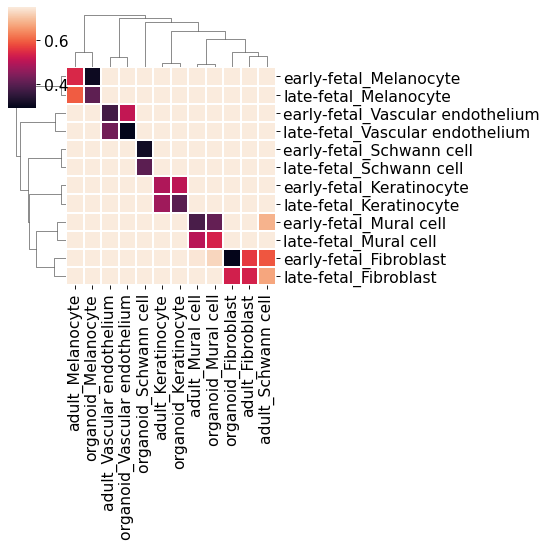

In [130]:
fig1Dp2_g = sn.clustermap(annot_scaled_dist_df_shared2.T, figsize=(7, 7), vmax=0.75, linewidth=0.01)
fig1Dp2_g.savefig("figures/obsolete/fig1D_p2a.pdf")

In [131]:
# !rclone copy --drive-shared-with-me figures/fig1D_p2a.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

### refined adult annotation

In [132]:
pooled_ad0.obs["annot_early_late2"] = pooled_ad0.obs.annot.astype(str)
pooled_ad0.obs.loc[
    pooled_ad0.obs.dataset == "adult", "annot_early_late2"
] = "adult_" + pooled_ad0.obs.loc[pooled_ad0.obs.dataset == "adult", "anno_final"].astype(str)
k_early_fsk = pooled_ad0.obs_names.isin(early_fsk_cells + "-fetal")
k_late_fsk = pooled_ad0.obs_names.isin(late_fsk_cells + "-fetal")
pooled_ad0.obs.loc[k_early_fsk, "annot_early_late2"] = (
    pooled_ad0.obs.loc[k_early_fsk, "annot_early_late2"] + ", early"
)
pooled_ad0.obs.loc[k_late_fsk, "annot_early_late2"] = (
    pooled_ad0.obs.loc[k_late_fsk, "annot_early_late2"] + ", late"
)
pooled_ad0.obs["annot_early_late2"] = pooled_ad0.obs["annot_early_late2"].astype("category")

In [133]:
pb_annot_pca3 = sk.pseudo_bulk(
    pooled_ad0[pooled_ad0.obs.dataset != "organoid"],
    groupby="annot_early_late2",
    use_rep="X_pca_project",
    FUN=np.median,
).T

In [134]:
annot_dist_df3 = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca3.values, pb_annot_pca3.values),
    index=pb_annot_pca3.index,
    columns=pb_annot_pca3.index,
)

In [135]:
annot_dist_df3.iloc[0:5, 0:5]

adult_C_Melanocyte  adult_DC1  adult_DC2   adult_F1  \
adult_C_Melanocyte            0.000000  31.699925  32.920710  35.620639   
adult_DC1                    31.699925   0.000000   8.297773  23.479541   
adult_DC2                    32.920710   8.297773   0.000000  24.530138   
adult_F1                     35.620639  23.479541  24.530138   0.000000   
adult_F2                     32.585339  19.998832  20.466602  10.448977   

                     adult_F2  
adult_C_Melanocyte  32.585339  
adult_DC1           19.998832  
adult_DC2           20.466602  
adult_F1            10.448977  
adult_F2             0.000000

In [136]:
annot_scaled_dist_df3 = pd.DataFrame(
    minmax_scale(np.log1p(annot_dist_df3)),
    index=annot_dist_df3.index,
    columns=annot_dist_df3.index,
)

In [137]:
annot_scaled_dist_df3e = annot_scaled_dist_df3.loc[
    annot_scaled_dist_df3.index.str.endswith(", early"),
    annot_scaled_dist_df3.index.str.startswith("adult_"),
]
annot_scaled_dist_df3l = annot_scaled_dist_df3.loc[
    annot_scaled_dist_df3.index.str.endswith(", late"),
    annot_scaled_dist_df3.index.str.startswith("adult_"),
]

In [138]:
annot_scaled_dist_df3e.index = annot_scaled_dist_df3e.index.str.replace(", early", "")
annot_scaled_dist_df3l.index = annot_scaled_dist_df3l.index.str.replace(", late", "")

In [139]:
annot_scaled_dist_df3 = annot_scaled_dist_df3.loc[
    annot_scaled_dist_df3.index.str.endswith(", early")
    | annot_scaled_dist_df3.index.str.endswith(", late"),
    annot_scaled_dist_df3.index.str.startswith("adult_"),
]

fig1D part2

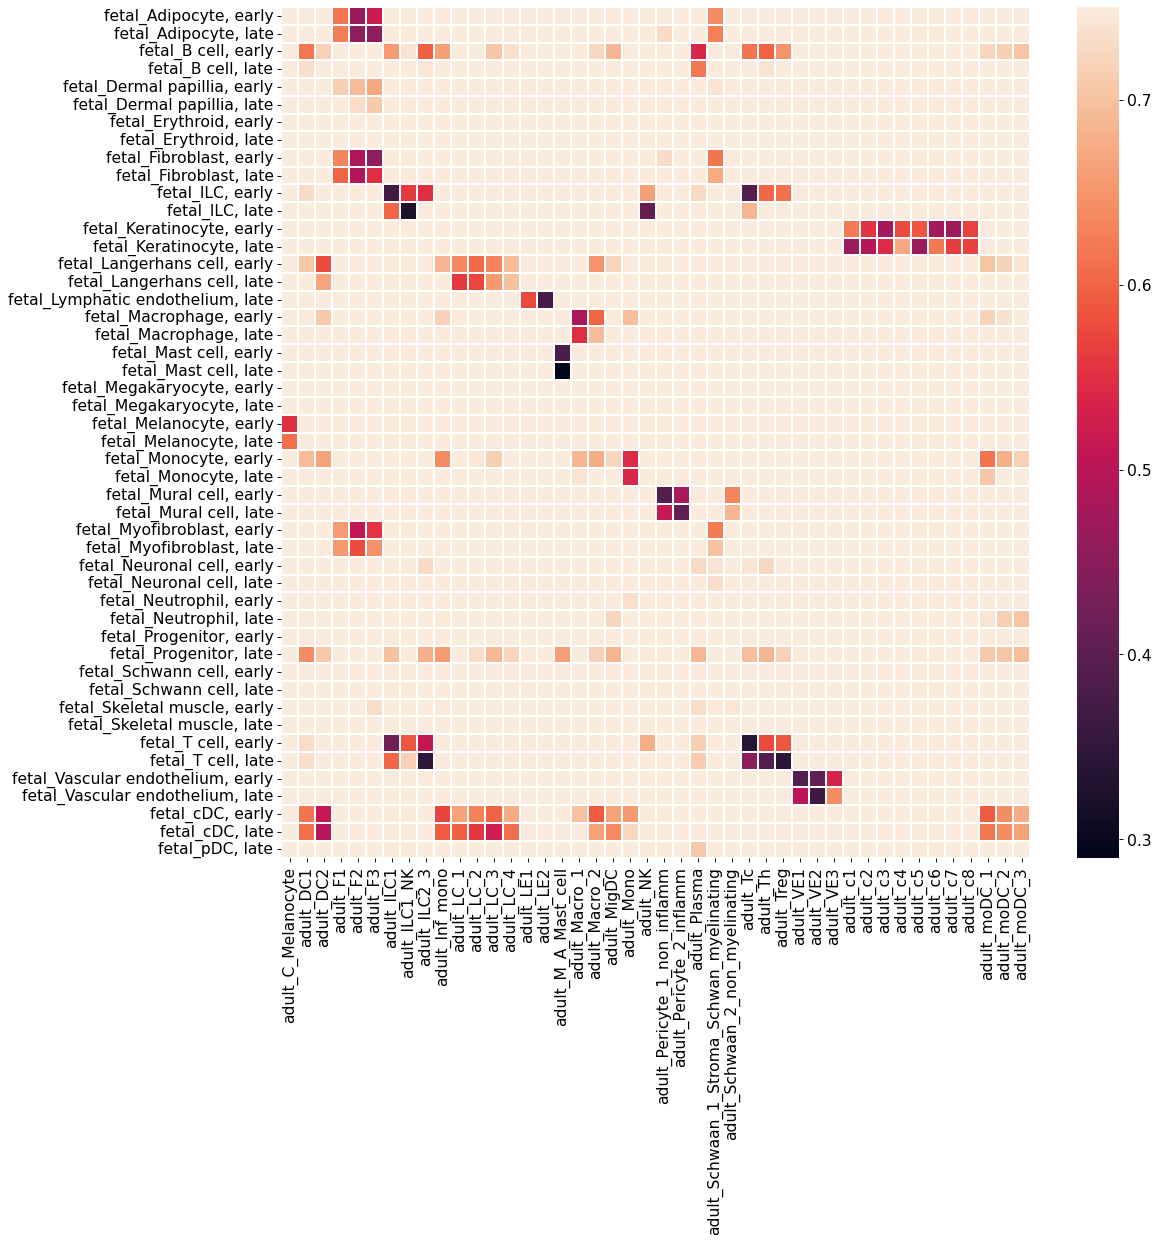

In [140]:
sk.set_figsize((15, 14))
fig1Dp2_g = sn.heatmap(annot_scaled_dist_df3, vmax=0.75, linewidth=0.01)
plt.savefig("figures/obsolete/fig1D_p2b.pdf", bbox_inches="tight")

In [141]:
# !rclone copy --drive-shared-with-me figures/fig1D_p2b.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

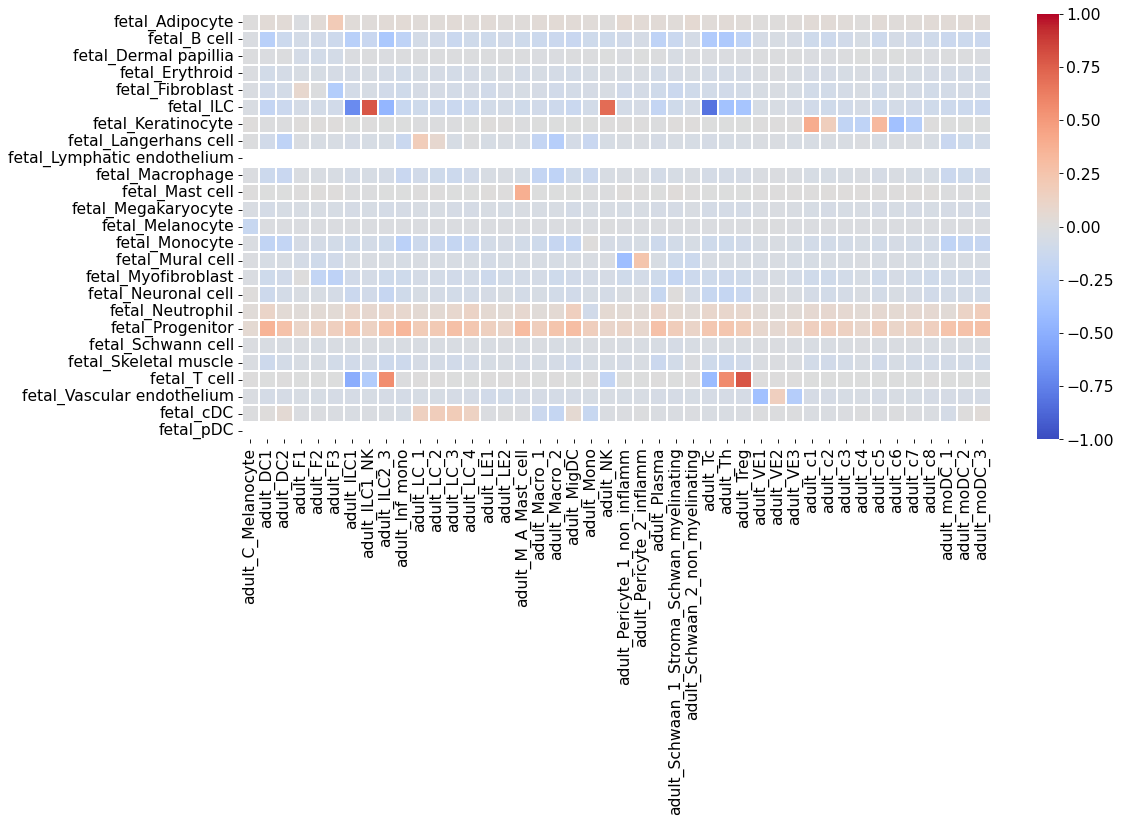

In [142]:
sk.set_figsize((15, 7))
fig1Dp2_g = sn.heatmap(
    np.log2(annot_scaled_dist_df3e / annot_scaled_dist_df3l),
    vmin=-1,
    vmax=1,
    linewidth=0.01,
    cmap="coolwarm",
)
plt.savefig("figures/obsolete/fig1D_p2c.pdf", bbox_inches="tight")

## between stages

In [143]:
pooled_ad0.obs.pcw.apply(lambda x: f"{x:03d}")

AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal    008
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal    008
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal    008
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal    008
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal    008
                                           ... 
TTTGGTTTCAGGCCCA-1-4820STDY7389014-adult    999
TTTGGTTTCGCCTGTT-1-4820STDY7389014-adult    999
TTTGTCAAGGAATCGC-1-4820STDY7389014-adult    999
TTTGTCAAGGACTGGT-1-4820STDY7389014-adult    999
TTTGTCACACTACAGT-1-4820STDY7389014-adult    999
Name: pcw, Length: 506107, dtype: object

In [144]:
pooled_ad0.obs["annot_timepoint"] = (
    pooled_ad0.obs.annot.astype(str) + ", " + pooled_ad0.obs.pcw.apply(lambda x: f"{x:03d}")
)
pooled_ad0.obs["annot_timepoint"] = pooled_ad0.obs["annot_timepoint"].astype("category")

In [145]:
pooled_ad0.obs.loc[pooled_ad0.obs.dataset != "adult", "annot"]

AAACCTGGTCAGTGGA-1-4834STDY7002879-fetal                  fetal_Macrophage
AAAGATGGTCGATTGT-1-4834STDY7002879-fetal                    fetal_Monocyte
AAAGCAAAGATGTGGC-1-4834STDY7002879-fetal                  fetal_Macrophage
AAAGTAGCAGATCGGA-1-4834STDY7002879-fetal                  fetal_Progenitor
AAAGTAGTCCGCATCT-1-4834STDY7002879-fetal                  fetal_Macrophage
                                                             ...          
day_13_IEOdev_DSP_d13:TTTCCTCCATACAGAAx-organoid    organoid_Neuronal cell
day_13_IEOdev_DSP_d13:TTTCGATGTTAAAGTGx-organoid    organoid_Neuronal cell
day_13_IEOdev_DSP_d13:TTTGATCAGTACCCTAx-organoid    organoid_Neuronal cell
day_13_IEOdev_DSP_d13:TTTGATCTCTGGCCGAx-organoid       organoid_Melanocyte
day_13_IEOdev_DSP_d13:TTTGATCCAGAACCGAx-organoid     organoid_Keratinocyte
Name: annot, Length: 310368, dtype: category
Categories (50, object): ['adult_Fibroblast', 'adult_ILC', 'adult_Keratinocyte', 'adult_Langerhans cell', ..., 'organoid_Neuronal 

In [147]:
ct_shared_by_fsk_org = (
    pooled_ad0.obs.loc[pooled_ad0.obs.dataset != "adult", "annot"]
    .unique()
    .categories.to_series()
    .str.partition("_")[2]
    .value_counts()
    .where(lambda x: x == 2)
    .dropna()
    .index.to_list()
)

In [148]:
ct_shared_by_fsk_org

['Macrophage',
 'ILC',
 'Skeletal muscle',
 'Neuronal cell',
 'Dermal papillia',
 'Mast cell',
 'cDC',
 'Adipocyte',
 'T cell',
 'Langerhans cell',
 'Monocyte',
 'Lymphatic endothelium']

In [149]:
pooled_ad0.obs.annot_timepoint.cat.categories

Index(['adult_Fibroblast, 999', 'adult_ILC, 999', 'adult_Keratinocyte, 999',
       'adult_Langerhans cell, 999', 'adult_Lymphatic endothelium, 999',
       'adult_Macrophage, 999', 'adult_Mast cell, 999',
       'adult_Melanocyte, 999', 'adult_Monocyte, 999', 'adult_Mural cell, 999',
       ...
       'organoid_Skeletal muscle, 002', 'organoid_Skeletal muscle, 004',
       'organoid_Skeletal muscle, 007', 'organoid_Skeletal muscle, 012',
       'organoid_Skeletal muscle, 019', 'organoid_Vascular endothelium, 002',
       'organoid_Vascular endothelium, 004',
       'organoid_Vascular endothelium, 007',
       'organoid_Vascular endothelium, 012',
       'organoid_Vascular endothelium, 019'],
      dtype='object', length=293)

In [150]:
pb_annot_timepoint_pca = sk.pseudo_bulk(
    pooled_ad0, groupby="annot_timepoint", use_rep="X_pca_project", FUN=np.mean
).T

In [151]:
dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_timepoint_pca.values, pb_annot_timepoint_pca.values),
    index=pb_annot_timepoint_pca.index,
    columns=pb_annot_timepoint_pca.index,
)

In [152]:
dist_df.shape

(293, 293)

In [153]:
dist_df.iloc[0:5, 0:5]

adult_Fibroblast, 999  adult_ILC, 999  \
adult_Fibroblast, 999                          0.000000       24.472987   
adult_ILC, 999                                24.472987        0.000000   
adult_Keratinocyte, 999                       22.631276       22.103532   
adult_Langerhans cell, 999                    23.344804       20.067903   
adult_Lymphatic endothelium, 999              21.969516       24.594516   

                                  adult_Keratinocyte, 999  \
adult_Fibroblast, 999                           22.631276   
adult_ILC, 999                                  22.103532   
adult_Keratinocyte, 999                          0.000000   
adult_Langerhans cell, 999                      20.108758   
adult_Lymphatic endothelium, 999                22.554506   

                                  adult_Langerhans cell, 999  \
adult_Fibroblast, 999                              23.344804   
adult_ILC, 999                                     20.067903   
adult_Keratinocyte, 999                            20.108758   
adult_Langerhans cell, 999                          0.000000   
adult_Lymphatic endothelium, 999                   23.396120   

                                  adult_Lymphatic endothelium, 999  
adult_Fibroblast, 999                                    21.969516  
adult_ILC, 999                                           24.594516  
adult_Keratinocyte, 999                                  22.554506  
adult_Langerhans cell, 999                               23.396120  
adult_Lymphatic endothelium, 999                          0.000000

In [154]:
dist_df.index.to_series().str.partition("_")[2].str.partition(", ")[0]

adult_Fibroblast, 999                            Fibroblast
adult_ILC, 999                                          ILC
adult_Keratinocyte, 999                        Keratinocyte
adult_Langerhans cell, 999                  Langerhans cell
adult_Lymphatic endothelium, 999      Lymphatic endothelium
                                              ...          
organoid_Vascular endothelium, 002     Vascular endothelium
organoid_Vascular endothelium, 004     Vascular endothelium
organoid_Vascular endothelium, 007     Vascular endothelium
organoid_Vascular endothelium, 012     Vascular endothelium
organoid_Vascular endothelium, 019     Vascular endothelium
Name: 0, Length: 293, dtype: object

In [155]:
dist_dfs = {}
for ct in ct_shared_by_fsk_org:
    tmp_df = dist_df.loc[
        dist_df.index.str.startswith("organoid_")
        & (dist_df.index.to_series().str.partition("_")[2].str.partition(", ")[0] == ct),
        dist_df.columns[
            dist_df.columns.str.startswith("fetal_")
            & (dist_df.columns.to_series().str.partition("_")[2].str.partition(", ")[0] == ct)
        ],
    ]
    if len(tmp_df) == 0:
        print(f"{ct} is not included in the dataset")
        continue
    dist_dfs[ct] = pd.DataFrame(
        minmax_scale(tmp_df, axis=0), index=tmp_df.index, columns=tmp_df.columns
    )

Macrophage is not included in the dataset
ILC is not included in the dataset
Mast cell is not included in the dataset
cDC is not included in the dataset
T cell is not included in the dataset
Langerhans cell is not included in the dataset
Monocyte is not included in the dataset
Lymphatic endothelium is not included in the dataset


In [156]:
pooled_ad0.obs.loc[
    pooled_ad0.obs.annot_timepoint.str.startswith("organoid_Vascular"), "annot_timepoint"
].value_counts().where(lambda x: x > 0).dropna().sort_index().astype(int)

organoid_Vascular endothelium, 002     1
organoid_Vascular endothelium, 004     7
organoid_Vascular endothelium, 007    45
organoid_Vascular endothelium, 012    66
organoid_Vascular endothelium, 019    12
Name: annot_timepoint, dtype: int64

In [157]:
for ct in ct_shared_by_fsk_org:
    sn.clustermap(
        dist_dfs[ct], figsize=(5, 5), linewidth=0.01, col_cluster=False, row_cluster=False
    );

KeyError: 'Macrophage'

# LR based on genes

In [ ]:
# ask_lr = sk.LR_train(
#     pooled_ad0[pooled_ad0.obs.dataset == "adult"],
#     groupby="annot",
#     use_rep="X",
#     downsample_to=(200, "tmp/adult_skin.norm.downsampled_for_LR.h5ad"),
#     save="models/LR_models/adult_broad.pooled_fsk_ask_org.lognorm.LR.pkl",
# )

In [ ]:
# fsk_lr = sk.LR_train(
#     pooled_ad0[pooled_ad0.obs.dataset == "fetal"],
#     groupby="annot",
#     use_rep="X",
#     downsample_to=(200, "tmp/fetal_skin.norm.downsampled_for_LR.h5ad"),
#     save="models/LR_models/fetal_broad.pooled_fsk_ask_org.lognorm.LR.pkl",
# )

In [ ]:
# org_lr = sk.LR_train(
#     pooled_ad0[pooled_ad0.obs.dataset == "organoid"],
#     groupby="annot",
#     use_rep="X",
#     downsample_to=(200, "tmp/organoid_skin.norm.downsampled_for_LR.h5ad"),
#     save="models/LR_models/organoid_broad.pooled_fsk_ask_org.lognorm.LR.pkl",
# )

In [ ]:
ask_lr = Path(data_root, '20211022_final_figures/LR_models/adult_broad.pooled_fsk_ask_org.lognorm.LR.pkl')
fsk_lr = Path(data_root, '20211022_final_figures/LR_models/fetal_broad.pooled_fsk_ask_org.lognorm.LR.pkl')
org_lr = Path(data_root, '20211022_final_figures/LR_models/organoid_broad.pooled_fsk_ask_org.lognorm.LR.pkl')
ask_lr = joblib.load(ask_lr)
fsk_lr = joblib.load(fsk_lr)
org_lr = joblib.load(org_lr)

In [ ]:
fsk_pred = sk.LR_predict(
    pooled_ad0, fsk_lr, use_rep="X", key_added="fsk_lognorm_annot", return_predict=True
)
ask_pred = sk.LR_predict(
    pooled_ad0, ask_lr, use_rep="X", key_added="ask_lognorm_annot", return_predict=True
)
org_pred = sk.LR_predict(
    pooled_ad0, org_lr, use_rep="X", key_added="org_lognorm_annot", return_predict=True
)

In [ ]:
fsk_pred_df = pd.DataFrame(
    npg.aggregate_np(pooled_ad0.obs.annot.cat.codes, fsk_pred["prob"].values, func=np.mean, axis=0),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=fsk_pred["prob"].columns,
)

In [ ]:
ask_pred_df = pd.DataFrame(
    npg.aggregate_np(pooled_ad0.obs.annot.cat.codes, ask_pred["prob"].values, func=np.mean, axis=0),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=ask_pred["prob"].columns,
)

In [ ]:
org_pred_df = pd.DataFrame(
    npg.aggregate_np(pooled_ad0.obs.annot.cat.codes, org_pred["prob"].values, func=np.mean, axis=0),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=org_pred["prob"].columns,
)

In [ ]:
pred_prob_df = pd.concat([fsk_pred_df, ask_pred_df, org_pred_df], axis=1)

In [ ]:
ct_shared_by_all = (
    pred_prob_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [ ]:
ct_shared_by_all

In [ ]:
pred_prob_df.loc[
    (
        ~pred_prob_df.columns.str.startswith("fetal_")
        & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
    ),
    (
        pred_prob_df.index.str.startswith("fetal_")
        & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
    ),
].T

In [ ]:
sn.clustermap(
    pred_prob_df.loc[
        (
            ~pred_prob_df.columns.str.startswith("fetal_")
            & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
        (
            pred_prob_df.index.str.startswith("fetal_")
            & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
    ].T,
    cmap="rocket_r",
    linewidth=0.01,
    # vmin=0,
    # vmax=1,
    figsize=(5, 4),
);

In [ ]:
sn.clustermap(
    np.log(
        1
        - pred_prob_df.loc[
            (
                ~pred_prob_df.columns.str.startswith("fetal_")
                & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
            ),
            (
                pred_prob_df.index.str.startswith("fetal_")
                & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
            ),
        ].T
    ),
    cmap="rocket",
    linewidth=0.01,
    figsize=(5, 4),
);

## between stages

In [ ]:
![[ ! -z `find '/lustre/scratch126/cellgen/team205/nh3/skin' -maxdepth 1000 -name 'fetal_Macrophage_by_timepoint.lognorm.pkl' -print 2>/dev/null` ]] && echo "found" || echo "not found"

In [ ]:
pooled_ad0.obs.dataset[(pooled_ad0.obs.dataset == "organoid")]

In [ ]:
pooled_ad0.obs.annot.unique().categories

In [ ]:
pooled_ad0[(pooled_ad0.obs.dataset == "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))]

In [ ]:
fsk_models = {}
fsk2org_predictions = {}
for ct in ct_shared_by_fsk_org:
    fsk_ad = pooled_ad0[
        (pooled_ad0.obs.dataset == "fetal") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    org_ad = pooled_ad0[
        (pooled_ad0.obs.dataset == "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    model_pkl = Path(data_root, f"20211022_final_figures/LR_models/fetal_{ct.replace(' ', '-')}_by_timepoint.lognorm.pkl")

    if os.path.exists(model_pkl):
        lr = joblib.load(model_pkl)
    else:
        lr = sk.LR_train(
            fsk_ad,
            groupby="annot_timepoint",
            use_rep="X",
            downsample_to=(200, "tmp/tmp.h5ad"),
            save=Path(proj_root, f"models/LR_models/fetal_{ct.replace(' ', '-')}_by_timepoint.lognorm.pkl"),
        )
    fsk_models[ct] = lr
    pred = sk.LR_predict(org_ad, lr, use_rep="X", return_predict=True)
    prob_df = pd.DataFrame(
        npg.aggregate_np(
            org_ad.obs.annot_timepoint.cat.codes,
            pred["prob"].values,
            func=np.median,
            axis=0,
        ),
        index=org_ad.obs.annot_timepoint.cat.categories,
        columns=pred["prob"].columns,
    )
    prop_df = pd.crosstab(org_ad.obs.annot_timepoint, pred["label"])
    fsk2org_predictions[ct] = {"prob": prob_df, "prop": prop_df}

In [ ]:
sk.set_figsize((4, 2))
for ct in ct_shared_by_fsk_org:
    sn.heatmap(
        fsk2org_predictions[ct]["prob"]
        / np.linalg.norm(fsk2org_predictions[ct]["prob"], ord=1, axis=0),
        cmap="viridis_r",
        linewidth=0.01,
        vmin=0.2,
        vmax=1,
    )
    plt.suptitle(f"Probability")
    plt.show()
    sn.heatmap(
        fsk2org_predictions[ct]["prop"],
        cmap="viridis_r",
        linewidth=0.01,
    )
    plt.suptitle(f"Proportion")
    plt.show()

In [ ]:
ct_shared_by_fsk_org

### probability

In [ ]:
mean_prob_df = (
    pd.concat(
        [
            pd.melt(fsk2org_predictions[ct]["prob"].reset_index(), id_vars=["index"])
            .assign(celltype=ct)
            .replace(regex={f"(fetal|organoid)_{ct}, 0": ""})
            for ct in ct_shared_by_fsk_org  # if ct not in ["Adipocyte"]
        ]
    )
    .rename(columns={"index": "organoid_stage", "variable": "fetal_stage", "value": "probability"})
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

In [ ]:
sn.heatmap(
    mean_prob_df / np.linalg.norm(mean_prob_df, ord=1, axis=0),
    vmin=0.1,
    vmax=0.9,
    cmap="viridis_r",
    linewidths=0.01,
)

In [ ]:
sn.heatmap(mean_prob_df, vmin=0.1, vmax=0.9, cmap="viridis_r", linewidths=0.01)

### proportion

In [ ]:
mean_prop_df = (
    pd.concat(
        [
            pd.melt(fsk2org_predictions[ct]["prop"].reset_index(), id_vars=["annot_timepoint"])
            .assign(celltype=ct)
            .astype({"annot_timepoint": str})
            .replace(regex={f"(fetal|organoid)_{ct}, 0": ""})
            for ct in ct_shared_by_fsk_org  # if ct not in ["Adipocyte"]
        ]
    )
    .rename(
        columns={
            "annot_timepoint": "organoid_stage",
            "col_0": "fetal_stage",
            "value": "probability",
        }
    )
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

In [ ]:
sn.heatmap(
    mean_prop_df / np.linalg.norm(mean_prop_df, ord=1, axis=0),
    vmin=0.1,
    vmax=0.9,
    cmap="viridis_r",
    linewidths=0.01,
)

In [ ]:
sn.heatmap(
    (mean_prop_df.T / np.linalg.norm(mean_prop_df.T, ord=1, axis=0)).T,
    vmin=0,
    vmax=1,
    cmap="viridis_r",
    linewidths=0.01,
)

In [ ]:
mean_prop_jaccard = mean_prop_df / (
    np.tile(np.linalg.norm(mean_prop_df, ord=1, axis=0), 5).reshape((5, 10))
    + np.repeat(np.linalg.norm(mean_prop_df, ord=1, axis=1), 10).reshape((5, 10))
)

In [ ]:
sn.heatmap(
    mean_prop_jaccard,
    # vmin=0,
    # vmax=1,
    cmap="viridis_r",
    linewidths=0.01,
)

## between stages including adult

In [158]:
pooled_ad0 = anndata.AnnData(
    **sk.read_h5ad(
        Path(data_root, "20211022_final_figures/h5ad/pooled_fetal_organoid_adult.processed.h5ad"), component=["X", "obs", "var", "obsm"]
    )
)

In [159]:
pb_annot_pca = sk.pseudo_bulk(pooled_ad0, groupby="annot", use_rep="X_pca_project", FUN=np.median).T

In [160]:
annot_dist_df = pd.DataFrame(
    scipy.spatial.distance_matrix(pb_annot_pca.values, pb_annot_pca.values),
    index=pb_annot_pca.index,
    columns=pb_annot_pca.index,
)

In [161]:
ct_shared_by_all = (
    annot_dist_df.index.to_series()
    .str.partition("_", expand=True)[2]
    .value_counts()
    .where(lambda x: x == 3)
    .dropna()
    .index
)

In [162]:
pooled_ad0.obs["annot_timepoint"] = (
    pooled_ad0.obs.annot.astype(str) + ", " + pooled_ad0.obs.pcw.apply(lambda x: f"{x:03d}")
)
pooled_ad0.obs["annot_timepoint"] = pooled_ad0.obs["annot_timepoint"].astype("category")

In [164]:
fask_models = {}
fask2org_predictions = {}
for ct in ct_shared_by_all:
    fask_ad = pooled_ad0[
        (pooled_ad0.obs.dataset != "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
    org_ad = pooled_ad0[
        (pooled_ad0.obs.dataset == "organoid") & (pooled_ad0.obs.annot.str.endswith(ct))
    ]
#     model_pkl = f"models/LR_models/fetal_adult_{ct.replace(' ', '-')}_by_timepoint.lognorm.pkl"
    model_pkl = Path(data_root, f"20211022_final_figures/LR_models/fetal_{ct.replace(' ', '-')}_by_timepoint.lognorm.pkl")
    lr = joblib.load(model_pkl)
    if os.path.exists(model_pkl):
        lr = joblib.load(model_pkl)
    else:
        lr = sk.LR_train(
            fask_ad,
            groupby="annot_timepoint",
            use_rep="X",
            downsample_to=(200, "tmp/tmp.h5ad"),
            save=model_pkl,
        )
    fask_models[ct] = lr
    pred = sk.LR_predict(
        org_ad, lr, use_rep="X", return_predict=True, key_added="fask_annot_timepoint"
    )
    prob_df = pd.DataFrame(
        npg.aggregate_np(
            org_ad.obs.annot_timepoint.cat.codes,
            pred["prob"].values,
            func=np.median,
            axis=0,
        ),
        index=org_ad.obs.annot_timepoint.cat.categories,
        columns=pred["prob"].columns,
    )
    prop_df = pd.crosstab(org_ad.obs.annot_timepoint, org_ad.obs.fask_annot_timepoint)
    jaccard_df = sk.cross_table(
        org_ad, "annot_timepoint", "fask_annot_timepoint", normalise="jaccard"
    )
    fask2org_predictions[ct] = {"prob": prob_df, "prop": prop_df, "jaccard": jaccard_df}

46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.
46794 features used for prediction
Trying to set attribute `.obs` of view, copying.


In [165]:
gc.collect()

2290

In [166]:
org_ad.obs.fask_annot_timepoint.unique()

['fetal_Keratinocyte, 016', 'fetal_Keratinocyte, 014', 'fetal_Keratinocyte, 007', 'fetal_Keratinocyte, 015', 'fetal_Keratinocyte, 008', 'fetal_Keratinocyte, 009']
Categories (6, object): ['fetal_Keratinocyte, 007', 'fetal_Keratinocyte, 008', 'fetal_Keratinocyte, 009', 'fetal_Keratinocyte, 014', 'fetal_Keratinocyte, 015', 'fetal_Keratinocyte, 016']

In [167]:
ct = "Fibroblast"

In [168]:
(
    fask2org_predictions[ct]["prob"]
    / np.linalg.norm(fask2org_predictions[ct]["prob"], ord=1, axis=0)
).rename(index=lambda x: x.split(", ")[1], columns=lambda x: x.split(", ")[1]).sort_index(
    axis=1
).rename(
    index=lambda x: x.lstrip("0"),
    columns=lambda x: x.lstrip("0").replace("999", "Adult"),
)

7         8         9        10        11        12        13  \
2   0.530377  0.326828  0.024081  0.025864  0.060378  0.016809  0.010117   
4   0.373084  0.269706  0.099909  0.176192  0.263717  0.045813  0.085003   
7   0.030818  0.276167  0.291790  0.305514  0.281599  0.026014  0.215233   
12  0.058167  0.059829  0.359831  0.261308  0.160553  0.840266  0.278957   
19  0.007554  0.067470  0.224389  0.231123  0.233754  0.071098  0.410689   

          14        15        16  
2   0.027974  0.011124  0.117150  
4   0.015438  0.010318  0.023885  
7   0.246766  0.119434  0.091227  
12  0.058288  0.215329  0.047813  
19  0.651534  0.643794  0.719925

In [169]:
fask2org_predictions[ct]["prob"]

fetal_Fibroblast, 007  fetal_Fibroblast, 008  \
organoid_Fibroblast, 002               0.565056               0.297408   
organoid_Fibroblast, 004               0.397479               0.245429   
organoid_Fibroblast, 007               0.032833               0.251308   
organoid_Fibroblast, 012               0.061970               0.054443   
organoid_Fibroblast, 019               0.008048               0.061397   

                          fetal_Fibroblast, 009  fetal_Fibroblast, 010  \
organoid_Fibroblast, 002               0.020993               0.012927   
organoid_Fibroblast, 004               0.087100               0.088063   
organoid_Fibroblast, 007               0.254378               0.152700   
organoid_Fibroblast, 012               0.313696               0.130606   
organoid_Fibroblast, 019               0.195619               0.115519   

                          fetal_Fibroblast, 011  fetal_Fibroblast, 012  \
organoid_Fibroblast, 002               0.007325               0.002103   
organoid_Fibroblast, 004               0.031994               0.005733   
organoid_Fibroblast, 007               0.034164               0.003255   
organoid_Fibroblast, 012               0.019478               0.105145   
organoid_Fibroblast, 019               0.028359               0.008897   

                          fetal_Fibroblast, 013  fetal_Fibroblast, 014  \
organoid_Fibroblast, 002               0.000578               0.001069   
organoid_Fibroblast, 004               0.004857               0.000590   
organoid_Fibroblast, 007               0.012299               0.009429   
organoid_Fibroblast, 012               0.015940               0.002227   
organoid_Fibroblast, 019               0.023468               0.024896   

                          fetal_Fibroblast, 015  fetal_Fibroblast, 016  
organoid_Fibroblast, 002               0.000785               0.037593  
organoid_Fibroblast, 004               0.000728               0.007664  
organoid_Fibroblast, 007               0.008430               0.029274  
organoid_Fibroblast, 012               0.015198               0.015343  
organoid_Fibroblast, 019               0.045439               0.231018

In [170]:
fask2org_predictions[ct]["jaccard"]

fask_annot_timepoint      fetal_Fibroblast, 007  fetal_Fibroblast, 008  \
annot_timepoint                                                          
organoid_Fibroblast, 002                 0.0219                 0.0063   
organoid_Fibroblast, 004                 0.5399                 0.2037   
organoid_Fibroblast, 007                 0.0166                 0.2388   
organoid_Fibroblast, 012                 0.0313                 0.0280   
organoid_Fibroblast, 019                 0.0010                 0.0354   

fask_annot_timepoint      fetal_Fibroblast, 009  fetal_Fibroblast, 010  \
annot_timepoint                                                          
organoid_Fibroblast, 002                 0.0000                 0.0000   
organoid_Fibroblast, 004                 0.0153                 0.0237   
organoid_Fibroblast, 007                 0.1477                 0.1213   
organoid_Fibroblast, 012                 0.2026                 0.1391   
organoid_Fibroblast, 019                 0.2596                 0.1153   

fask_annot_timepoint      fetal_Fibroblast, 011  fetal_Fibroblast, 012  \
annot_timepoint                                                          
organoid_Fibroblast, 002                 0.0000                 0.0000   
organoid_Fibroblast, 004                 0.0019                 0.0000   
organoid_Fibroblast, 007                 0.0012                 0.0000   
organoid_Fibroblast, 012                 0.0005                 0.1710   
organoid_Fibroblast, 019                 0.0030                 0.0012   

fask_annot_timepoint      fetal_Fibroblast, 013  fetal_Fibroblast, 014  \
annot_timepoint                                                          
organoid_Fibroblast, 002                 0.0000                 0.0000   
organoid_Fibroblast, 004                 0.0000                 0.0000   
organoid_Fibroblast, 007                 0.0009                 0.0001   
organoid_Fibroblast, 012                 0.0010                 0.0000   
organoid_Fibroblast, 019                 0.0009                 0.0081   

fask_annot_timepoint      fetal_Fibroblast, 015  fetal_Fibroblast, 016  
annot_timepoint                                                         
organoid_Fibroblast, 002                 0.0000                 0.0002  
organoid_Fibroblast, 004                 0.0000                 0.0002  
organoid_Fibroblast, 007                 0.0000                 0.0220  
organoid_Fibroblast, 012                 0.0008                 0.0012  
organoid_Fibroblast, 019                 0.0177                 0.4408

In [171]:
fask2org_predictions[ct]["jaccard"].rename(columns={"Uncertain": ", Uncertain"}).rename(
    index=lambda x: x.split(", ")[1], columns=lambda x: x.split(", ")[1]
).sort_index(axis=1).rename(
    index=lambda x: x.lstrip("0"),
    columns=lambda x: x.lstrip("0").replace("999", "Adult"),
)

fask_annot_timepoint       7       8       9      10      11      12      13  \
annot_timepoint                                                                
2                     0.0219  0.0063  0.0000  0.0000  0.0000  0.0000  0.0000   
4                     0.5399  0.2037  0.0153  0.0237  0.0019  0.0000  0.0000   
7                     0.0166  0.2388  0.1477  0.1213  0.0012  0.0000  0.0009   
12                    0.0313  0.0280  0.2026  0.1391  0.0005  0.1710  0.0010   
19                    0.0010  0.0354  0.2596  0.1153  0.0030  0.0012  0.0009   

fask_annot_timepoint      14      15      16  
annot_timepoint                               
2                     0.0000  0.0000  0.0002  
4                     0.0000  0.0000  0.0002  
7                     0.0001  0.0000  0.0220  
12                    0.0000  0.0008  0.0012  
19                    0.0081  0.0177  0.4408

In [172]:
for ct in ct_shared_by_all:
    for dtyp in ("prob", "prop", "jaccard"):
        fask2org_predictions[ct][dtyp] = (
            fask2org_predictions[ct][dtyp]
            .rename(columns={"Uncertain": ", Uncertain"})
            .rename(index=lambda x: x.split(", ")[1], columns=lambda x: x.split(", ")[1])
            .sort_index(axis=1)
            .rename(
                index=lambda x: x.lstrip("0"),
                columns=lambda x: x.lstrip("0").replace("999", "Adult"),
            )
        )

In [173]:
def stage_align_heatmap(df, label=None, save=None, **kwargs):
    df1 = df.drop(columns=["Uncertain"]) if "Uncertain" in df.columns else df
    nrow, ncol = df1.shape
    ax = sk.heatmap(
        df1,
        cmap="viridis_r",
        figsize=(0.4 * ncol + 0.5, 0.3 * (nrow + 1)),
        **kwargs,
    )
    ax.invert_yaxis()
    ax.set_xlabel("Fetal stage (post-conception week)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_ylabel("Organoid stage\n(week)")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.axvline(x=ncol - 1, c="k", linewidth=0.5)

    fig = ax.get_figure()

    if label:
        fig.axes[1].set_ylabel(label)

    if save:
        fig.savefig(fname=save, bbox_inches="tight")

    return ax

<AxesSubplot: xlabel='Fetal stage (post-conception week)', ylabel='Organoid stage\n(week)'>

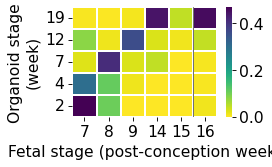

In [174]:
stage_align_heatmap(fask2org_predictions[ct]["jaccard"])

<AxesSubplot: xlabel='Fetal stage (post-conception week)', ylabel='Organoid stage\n(week)'>

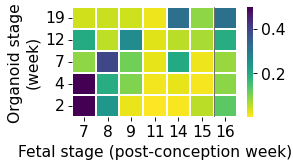

In [175]:
stage_align_heatmap(fask2org_predictions[ct]["prob"])

Text(0.5, 1.0, 'Keratinocyte, Probability')

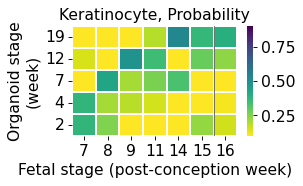

In [176]:
p1 = stage_align_heatmap(
    fask2org_predictions[ct]["prob"]
    / np.linalg.norm(fask2org_predictions[ct]["prob"], ord=1, axis=0),
    vmin=0.1,
    vmax=0.9,
)
p1.set_title(f"{ct}, Probability")

### probability

In [177]:
mean_prob_df = (
    pd.concat(
        [
            pd.melt(fask2org_predictions[ct]["prob"].reset_index(), id_vars=["index"])
            .assign(celltype=ct)
            .replace(regex={f"(fetal|organoid|adult)_{ct}, ": ""})
            for ct in ct_shared_by_all
        ]
    )
    .rename(columns={"index": "organoid_stage", "variable": "fetal_stage", "value": "probability"})
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

In [178]:
mean_prob_df.index = ["2", "4", "7", "12", "19"]
mean_prob_df.columns = ["7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

In [179]:
mean_prob_df

7         8         9        10        11        12        13  \
2   0.275992  0.037826  0.057057  0.031484  0.015257  0.029411  0.042617   
4   0.263523  0.023829  0.030124  0.058157  0.140208  0.083204  0.130359   
7   0.102973  0.009766  0.004000  0.003335  0.002612  0.010676  0.036620   
12  0.187271  0.038735  0.004013  0.004347  0.004484  0.002289  0.018842   
19  0.246959  0.030234  0.010547  0.023837  0.065057  0.011377  0.024016   

          14        15        16  
2   0.092729  0.131229  0.221464  
4   0.030707  0.084195  0.088799  
7   0.588037  0.209444  0.028723  
12  0.397095  0.243328  0.077355  
19  0.072208  0.352637  0.141437

In [180]:
mean_prob_jaccard = mean_prob_df / (
    np.tile(np.linalg.norm(mean_prob_df, ord=1, axis=0), 5).reshape((5, 11))
    + np.repeat(np.linalg.norm(mean_prob_df, ord=1, axis=1), 11).reshape((5, 11))
    - mean_prob_df
)

ValueError: cannot reshape array of size 50 into shape (5,11)

### proportion

In [ ]:
mean_prop_df = (
    pd.concat(
        [
            pd.melt(fask2org_predictions[ct]["prop"].reset_index(), id_vars=["annot_timepoint"])
            .assign(celltype=ct)
            .astype({"annot_timepoint": str})
            .replace(regex={f"(fetal|organoid|adult)_{ct}, ": ""})
            for ct in ct_shared_by_all  # if ct not in ["Adipocyte"]
        ]
    )
    .rename(
        columns={
            "annot_timepoint": "organoid_stage",
            "col_0": "fetal_stage",
            "value": "probability",
        }
    )
    .groupby(["organoid_stage", "fetal_stage"])
    .mean()
    .reset_index()
    .pivot(index=["organoid_stage"], columns=["fetal_stage"])
    .droplevel(0, axis=1)
)

In [ ]:
mean_prop_df.index = ["2", "4", "7", "12", "19"]
mean_prop_df.columns = ["7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "Adult"]

In [ ]:
mean_prop_jaccard = mean_prop_df / (
    np.tile(np.linalg.norm(mean_prop_df, ord=1, axis=0), 5).reshape((5, 11))
    + np.repeat(np.linalg.norm(mean_prop_df, ord=1, axis=1), 11).reshape((5, 11))
    - mean_prop_df
)

### plot

In [ ]:
stage_align_heatmap(mean_prop_jaccard, save="figures/final/fig1F", label="Jaccard index");

In [ ]:
stage_align_heatmap(mean_prop_df, label="Cell count");

In [ ]:
with PdfPages(filename="figures/final/figS1J.20221012.pdf") as pdf:
    for ct in ct_shared_by_all:
        p1 = stage_align_heatmap(
            fask2org_predictions[ct]["prob"],
            # / np.linalg.norm(fask2org_predictions[ct]["prob"], ord=1, axis=0),
            label="Probability",
            vmin=0,
            vmax=1,
        )
        # p1.axvline(x=fask2org_predictions[ct]["prob"].shape[1] - 1, c="k")
        p1.set_title(ct)
        pdf.savefig(p1.get_figure(), bbox_inches="tight")
        plt.show()

        # p2 = stage_align_heatmap(
        #     fask2org_predictions[ct]["prop"]
        #     / np.linalg.norm(fask2org_predictions[ct]["prop"], ord=1, axis=1)[:, np.newaxis],
        #     label="Proportion",
        # )
        # p2.set_title(ct)
        # pdf.savefig(p2.figure, bbox_inches="tight")
        # plt.show()

        p3 = stage_align_heatmap(fask2org_predictions[ct]["jaccard"], label="Jaccard index")
        p3.set_title(ct)
        # p3.axvline(x=fask2org_predictions[ct]["jaccard"].shape[1] - 2, c="k")
        pdf.savefig(p3.figure, bbox_inches="tight")
        plt.show()

In [ ]:
# !rclone copy --drive-shared-with-me fsk_org_similarity_by_stage_by_compartment.20221012.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

In [ ]:
sk.set_figsize((4, 2))
with PdfPages(
    filename="figures/obsolete/fig1F.20221011.pdf"
) as pdf:
    p1 = stage_align_heatmap(
        mean_prob_df / np.linalg.norm(mean_prob_df, ord=1, axis=0),
        vmin=0.1,
        vmax=0.9,
    )
    p1.set_title("Probability normalised by column")
    pdf.savefig(p1.get_figure(), bbox_inches="tight")
    plt.show()

    p2 = stage_align_heatmap(mean_prob_df, vmin=0.1, vmax=0.9)
    p2.set_title("Probability normalised by row")
    pdf.savefig(p2.get_figure(), bbox_inches="tight")
    plt.show()

    # p3 = stage_align_heatmap(mean_prob_jaccard)
    # p3.set_title("Probability-derived jaccard index")
    # pdf.savefig(p3.get_figure(), bbox_inches="tight")
    # plt.show()

    p4 = stage_align_heatmap(
        mean_prop_df / np.linalg.norm(mean_prop_df, ord=1, axis=0), vmin=0, vmax=1
    )
    p4.set_title("Proportion normalised by column")
    pdf.savefig(p4.get_figure(), bbox_inches="tight")
    plt.show()

    p5 = stage_align_heatmap(
        (mean_prop_df.T / np.linalg.norm(mean_prop_df.T, ord=1, axis=0)).T, vmin=0, vmax=1
    )
    p5.set_title("Proportion normalised by row")
    pdf.savefig(p5.get_figure(), bbox_inches="tight")
    plt.show()

    p6 = stage_align_heatmap(mean_prop_jaccard)
    p6.set_title("Jaccard index")
    pdf.savefig(p6.get_figure(), bbox_inches="tight")
    plt.show()

In [ ]:
# !rclone copy --drive-shared-with-me fsk_org_similarity_by_stage_average_across_compartment.20221011.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"

# LR based on PCs

In [ ]:
ask_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "adult"],
    groupby="annot",
    use_rep="X_pca_project",
    save="models/LR_models/adult.pooled_fsk_ask_org.pca_projection.LR.pkl",
)

In [ ]:
fsk_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "fetal"],
    groupby="annot",
    use_rep="X_pca_project",
    save="models/LR_models/fetal.pooled_fsk_adt_org.pca_projection.LR.pkl",
)

In [ ]:
org_lr = sk.LR_train(
    pooled_ad0[pooled_ad0.obs.dataset == "organoid"],
    groupby="annot",
    use_rep="X_pca_project",
    save="models/LR_models/organoid.pooled_fsk_adt_org.pca_projection.LR.pkl",
)

In [ ]:
fsk_pred = sk.LR_predict(
    pooled_ad0, fsk_lr, use_rep="X_pca_project", key_added="fsk_annot_pca", return_predict=True
)
ask_pred = sk.LR_predict(
    pooled_ad0, ask_lr, use_rep="X_pca_project", key_added="ask_annot_pca", return_predict=True
)
org_pred = sk.LR_predict(
    pooled_ad0, org_lr, use_rep="X_pca_project", key_added="org_annot_pca", return_predict=True
)

In [ ]:
fsk_pred_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_ad0.obs.annot.cat.codes, fsk_pred["prob"].values, func=np.median, axis=0
    ),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=fsk_pred["prob"].columns,
)

In [ ]:
ask_pred_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_ad0.obs.annot.cat.codes, ask_pred["prob"].values, func=np.median, axis=0
    ),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=ask_pred["prob"].columns,
)

In [ ]:
org_pred_df = pd.DataFrame(
    npg.aggregate_np(
        pooled_ad0.obs.annot.cat.codes, org_pred["prob"].values, func=np.median, axis=0
    ),
    index=pooled_ad0.obs.annot.cat.categories,
    columns=org_pred["prob"].columns,
)

In [ ]:
fsk_pred_df.shape, ask_pred_df.shape, org_pred_df.shape

In [ ]:
pred_prob_df = pd.concat([fsk_pred_df, ask_pred_df, org_pred_df], axis=1)

In [ ]:
sn.clustermap(
    pred_prob_df.loc[
        (
            ~pred_prob_df.columns.str.startswith("fetal_")
            & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
        (
            pred_prob_df.index.str.startswith("fetal_")
            & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all)
        ),
    ].T,
    cmap="rocket_r",
    linewidth=0.01,
    vmin=0.5,
    vmax=1,
    figsize=(5, 4),
);

In [ ]:
sn.clustermap(
    np.log1p(
        1
        / fsk_pred_df.loc[
            ~pred_prob_df.columns.str.startswith("fetal_")
            & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all),
            pred_prob_df.index.str.startswith("fetal_")
            & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all),
        ].T
    ),
    cmap="rocket",
    vmax=2,
    linewidth=0.01,
    figsize=(5, 4),
)

In [ ]:
fsk_pred_df.loc[
    ~pred_prob_df.columns.str.startswith("fetal_")
    & pred_prob_df.columns.to_series().str.partition("_")[2].isin(ct_shared_by_all),
    pred_prob_df.index.str.startswith("fetal_")
    & pred_prob_df.index.to_series().str.partition("_")[2].isin(ct_shared_by_all),
].T

In [ ]:
sn.clustermap(pred_prob_df, cmap="rocket_r", linewidth=0.01, figsize=(15, 15))